# Исследование алгоритмов для регулярных запросов #

## Постановка задачи ##

Проанализировать производительность алгоритмов решения задачи достижимости.

Исследуются следующие задачи достижимости, решаемые в предыдущих работах.
1) Достижимость между всеми парами вершин.
2) Достижимость для каждой из заданного множества стартовых вершин.

Вопросы, на которые необходимо ответить в ходе исследования.
1) Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?
2) Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?

## Описание исследуемых решений ##

### tensor based rpq (Достижимость между всеми парами вершин) ###

```Python
def tensor_based_rpq(regex: str, graph: MultiDiGraph, start_nodes: set[int],
      final_nodes: set[int]) -> set[tuple[int, int]]:
   pass
```

Алгоритм поиска путей в графе, удовлетворяющих заданному регулярному выражению, основанный на тензорном произведении матриц смежности dfa(построенного по regex) и nfa(построенного по graph, start_nodes, final_nodes). 

### multi source bfs based rpq (Достижимость для каждой из заданного множества стартовых вершин) ###

```Python
def ms_bfs_based_rpq(regex: str, graph: MultiDiGraph, start_nodes: set[int],
         final_nodes: set[int]) -> set[tuple[int, int]]:
  pass
```

Алгоритм поиска путей в графе, удовлетворяющих заданному регулярному выражению, основанный на multi source bfs.

## Описание набора данных для экспериментов ##

### Графы ###

Для проведения эксперимента были выбраны следующие графы из [набора](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/index.html): `generations`, `univ`, `foaf`, `wc`, `bzip`, `pr`.

1) Были выбраны графы, как имеющие много различных `label`, так и имеющие мало различных `label`.
2) Были выбраны и графы, в которых `nodes_count` > `edges_count` и графы, в которых `nodes_count` < `edges_count`.
- generations, univ, foaf - графы, в которых кол-во ребер > кол-ва вершин
- wc, bzip, pr - графы, в которых кол-во ребер < кол-ва вершин
3) Все выбранные графы имеют имеют маленькое количество вершин (max == 815), поскольку на большом количестве вершин многократный запуск алгоритмов длится слишком долго.

### Запросы ### 

Для проведения эксперимента были выбраны следующие шаблоны запросов:

1) `l1* (l2 | l3)*`
2) `l1* | l2* | l3*`
3) `l1* l2* l3*`
4) `(l1 l2)* | (l2 l3)*`

Для графов, в которых кол-во различных `label` на ребрах меньше трех, возьмем в запросах `l2 == l3`.

### Множества стартовых вершин ###

Для генерации множеств стартовых вершин используется [функция](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/reference/graphs/generated/cfpq_data.graphs.utils.multiple_source_utils.html#cfpq_data.graphs.utils.multiple_source_utils.generate_multiple_source).

## Описание эксперимента

### Оборудование

OC: Windows 11 Pro 23H2
Processor: 13th Gen Intel(R) Core(TM) i7-1355U
RAM: 32.0 GB

Python version: 3.12.5

## Ход эксперимента

### Подготовка

In [2]:
import math

import cfpq_data
import networkx as nx
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt

from scipy import sparse
from dataclasses import dataclass
from collections import defaultdict

from algo.typed_rpq import tensor_based_rpq, ms_bfs_based_rpq

import sources directory


In [3]:
GRAPHS_NAMES = ["generations", "univ", "foaf", "wc", "bzip", "pr"]


def get_graph_by_name(name):
    graph_csv = cfpq_data.download(name)
    return cfpq_data.graph_from_csv(graph_csv)


GRAPHS = []

for graph_name in GRAPHS_NAMES:
    GRAPHS.append((graph_name, get_graph_by_name(graph_name)))

[2025-01-28 09:38:23]>INFO>Found graph with name='generations'
[2025-01-28 09:38:23]>INFO>Load archive graph_archive=WindowsPath('C:/Users/tepa46/PycharmProjects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2025-01-28 09:38:23]>INFO>Unzip graph name='generations' to file graph=WindowsPath('C:/Users/tepa46/PycharmProjects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2025-01-28 09:38:23]>INFO>Remove archive graph_archive=WindowsPath('C:/Users/tepa46/PycharmProjects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2025-01-28 09:38:23]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000001CFDDDECCB0> from path=WindowsPath('C:/Users/tepa46/PycharmProjects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2025-01-28 09:38:23]>INFO>Found graph with name='univ'
[2025-01-28 09:38:24]>INFO>Load arc

In [4]:
regex_1 = "l1* ( l2 | l3 )"


def get_regex_1(label1, label2, label3):
    return f"{label1}* ( {label2} | {label3} )"


regex_2 = "l1* | l2* | l3*"


def get_regex_2(label1, label2, label3):
    return f"{label1}* | {label2}* | {label3}*"


regex_3 = "l1* l2* l3*"


def get_regex_3(label1, label2, label3):
    return f"{label1}* {label2}* {label3}*"


regex_4 = "( l1 l2 )* | ( l2 l3 )*"


def get_regex_4(label1, label2, label3):
    return f"( {label1} {label2} )* | ( {label2} {label3} )*"


def get_regexes_info(graph):
    graph_labels = cfpq_data.get_sorted_labels(graph)

    label1 = graph_labels[0]
    label2 = graph_labels[1 % len(graph_labels)]
    label3 = graph_labels[2 % len(graph_labels)]
    return [
        (regex_1, get_regex_1(label1, label2, label3)),
        (regex_2, get_regex_2(label1, label2, label3)),
        (regex_3, get_regex_3(label1, label2, label3)),
        (regex_4, get_regex_4(label1, label2, label3)),
    ]

In [5]:
seed = 42


def generate_start_states_set(graph, number_of_states):
    return cfpq_data.generate_multiple_source(graph, number_of_states, seed=seed)


K = [0.05, 0.2, 1]


def generate_start_states_list(graph):
    start_states = []
    for k in K:
        start_states.append(
            generate_start_states_set(graph, int(graph.number_of_nodes() * k))
        )

    return start_states

In [6]:
RPQ_ALGOS = [tensor_based_rpq, ms_bfs_based_rpq]

SPARSE_MATRICES_TYPES = [
    sparse.csr_matrix,
    sparse.csc_matrix,
    sparse.coo_matrix,
]
SPARSE_MATRICES_TYPES_NAMES = list(
    matrix_type.__name__ for matrix_type in SPARSE_MATRICES_TYPES
)

In [7]:
@dataclass
class RpqComputingResults:
    algorithm_name: str
    graph_name: str
    regex_scheme: str
    start_nodes_number: int
    sparse_matrix_type: str
    mean_time: str
    std_time: str

In [8]:
NUMBER_OF_LAUNCHES = 30

In [9]:
def compute_rpq(
    rpq_algorithm,
    sparse_matrix_type,
    graph: nx.MultiDiGraph,
    graph_name: str,
    regex: str,
    regex_scheme: str,
    start_nodes: set[int],
) -> RpqComputingResults:
    times = []
    for _ in range(NUMBER_OF_LAUNCHES):
        time = timeit.timeit(
            lambda: rpq_algorithm(regex, graph, start_nodes, set(), sparse_matrix_type),
            number=1,
        )
        times.append(time)

    times = sorted(times)[3:-3]
    mean = np.mean(times)
    std = np.std(times)
    order = max(math.ceil(-math.log10(std)), 0)

    return RpqComputingResults(
        rpq_algorithm.__name__,
        graph_name,
        regex_scheme,
        len(start_nodes),
        sparse_matrix_type.__name__,
        f"{mean:.{order}f}",
        f"{std:.{order}f}",
    )

In [10]:
results = []

for graph_info in GRAPHS:
    graph = graph_info[1]
    graph_name = graph_info[0]
    start_states_list = generate_start_states_list(graph)
    regexes_info = get_regexes_info(graph)
    for start_states in start_states_list:
        for algo in RPQ_ALGOS:
            for matrix_type in SPARSE_MATRICES_TYPES:
                for regex_info in regexes_info:
                    regex_scheme = regex_info[0]
                    regex = regex_info[1]
                    results.append(
                        compute_rpq(
                            algo,
                            matrix_type,
                            graph,
                            graph_name,
                            regex,
                            regex_scheme,
                            start_states,
                        )
                    )

pd.DataFrame(results)

[2025-01-28 09:38:25]>INFO>Generate set of source vertices of 6 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000001CFDDDECCB0> for multiple-source evaluation
[2025-01-28 09:38:25]>INFO>Generate set of source vertices of 25 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000001CFDDDECCB0> for multiple-source evaluation
[2025-01-28 09:38:25]>INFO>Generate set of source vertices of 129 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000001CFDDDECCB0> for multiple-source evaluation
[2025-01-28 09:38:25]>INFO>Construct labels_frequency=defaultdict(<class 'int'>, {'rest': 45, 'first': 45, 'onProperty': 27, 'type': 78, 'hasValue': 12, 'someValuesFrom': 15, 'equivalentClass': 17, 'intersectionOf': 18, 'inverseOf': 2, 'range': 1, 'hasSibling': 1, 'sameAs': 2, 'hasParent': 2, 'hasSex': 4, 'hasChild': 2, 'versionInfo': 1, 'oneOf': 1}) for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000001CFDDDECCB0>
[2025

,algorithm_name,graph_name,regex_scheme,start_nodes_number,sparse_matrix_type,mean_time,std_time
0,tensor_based_rpq,generations,l1* ( l2 | l3 ),6,csr_matrix,0.0066,0.0005
1,tensor_based_rpq,generations,l1* | l2* | l3*,6,csr_matrix,0.0110,0.0003
2,tensor_based_rpq,generations,l1* l2* l3*,6,csr_matrix,0.0093,0.0002
3,tensor_based_rpq,generations,( l1 l2 )* | ( l2 l3 )*,6,csr_matrix,0.0094,0.0003
4,tensor_based_rpq,generations,l1* ( l2 | l3 ),6,csc_matrix,0.0060,0.0002
...,...,...,...,...,...,...,...
427,ms_bfs_based_rpq,pr,( l1 l2 )* | ( l2 l3 )*,815,csc_matrix,1.528,0.009
428,ms_bfs_based_rpq,pr,l1* ( l2 | l3 ),815,coo_matrix,0.713,0.003
429,ms_bfs_based_rpq,pr,l1* | l2* | l3*,815,coo_matrix,1.060,0.004
430,ms_bfs_based_rpq,pr,l1* l2* l3*,815,coo_matrix,1.236,0.006


## 1. Представление разреженных матриц ##

В ходе эксперимента будут проведены замеры на 3 разных представлениях разреженных матриц:
1) `csr_matrix`
2) `csc_matrix`
3) `coo_matrix`

Дополнительно, запуски будут проводиться на различных графах, различном количестве стартовых вершин и различных регулярных выражениях. 

Для проведения эксперимента была проведена модернизация алгоритмов, поскольку для работы с этими матрицами используются разные механизмы. Модернизированные алгоритмы представлены в `typed_rpq.py`.
    

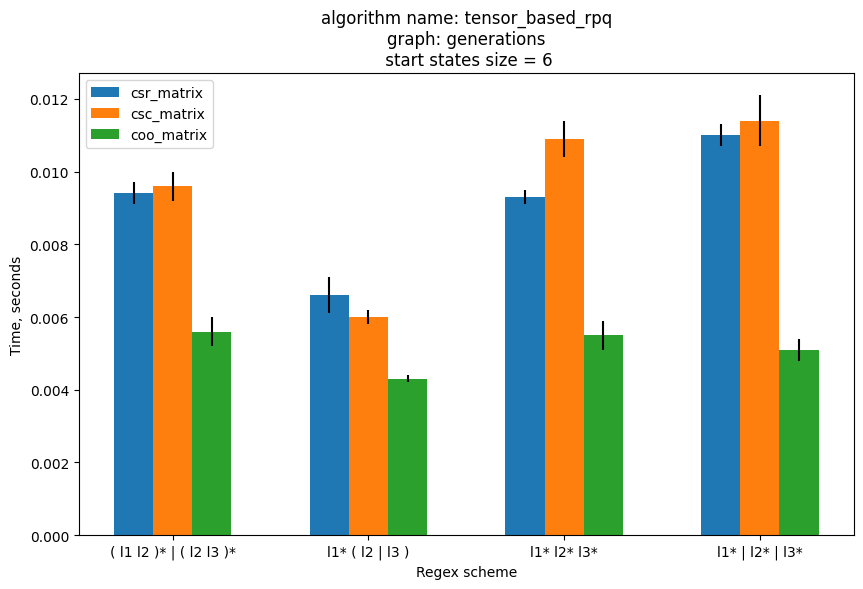

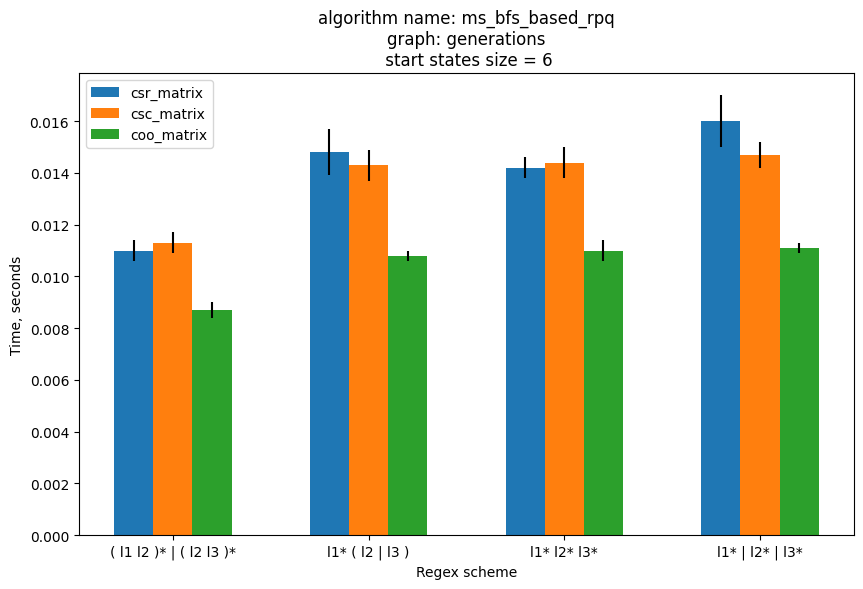

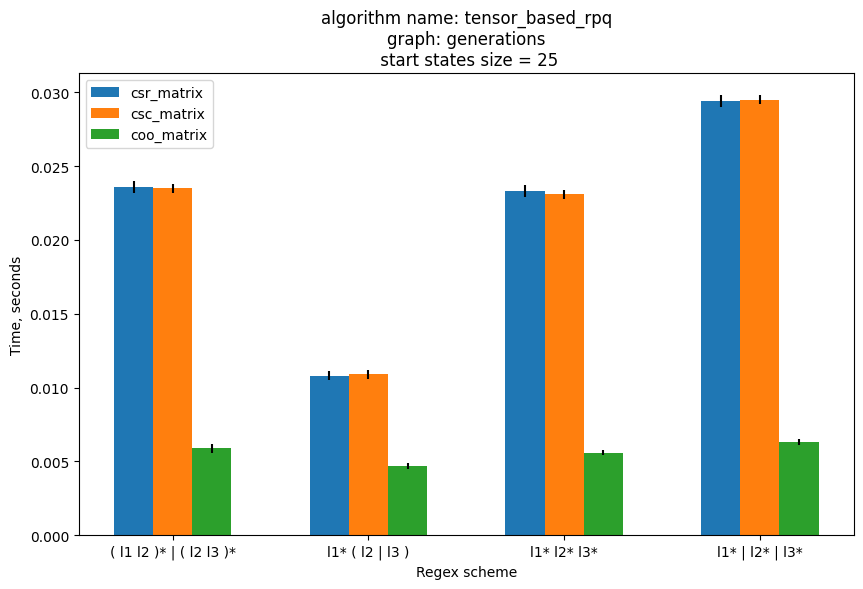

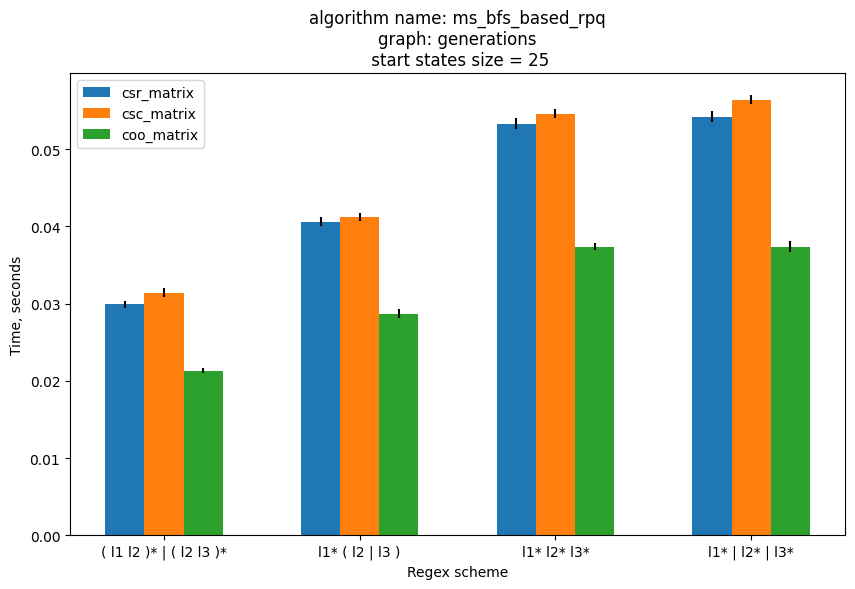

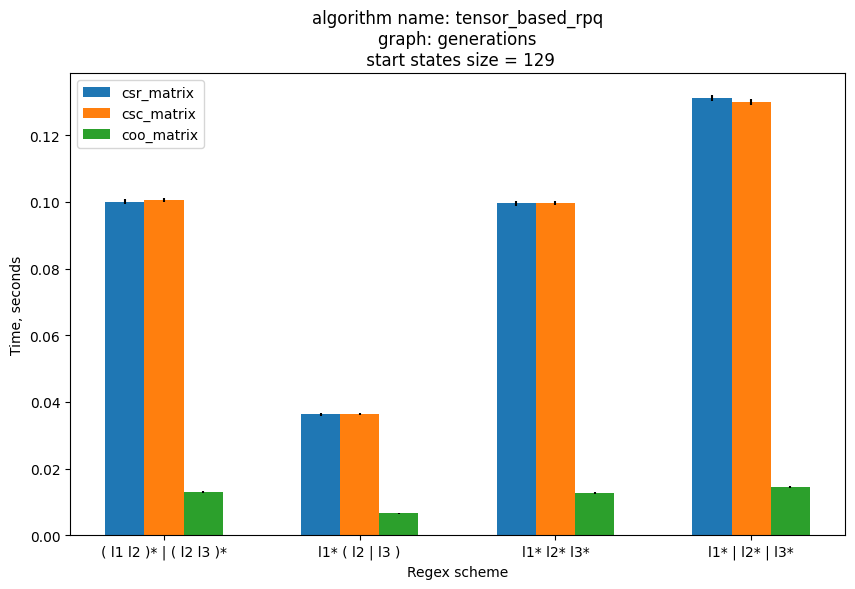

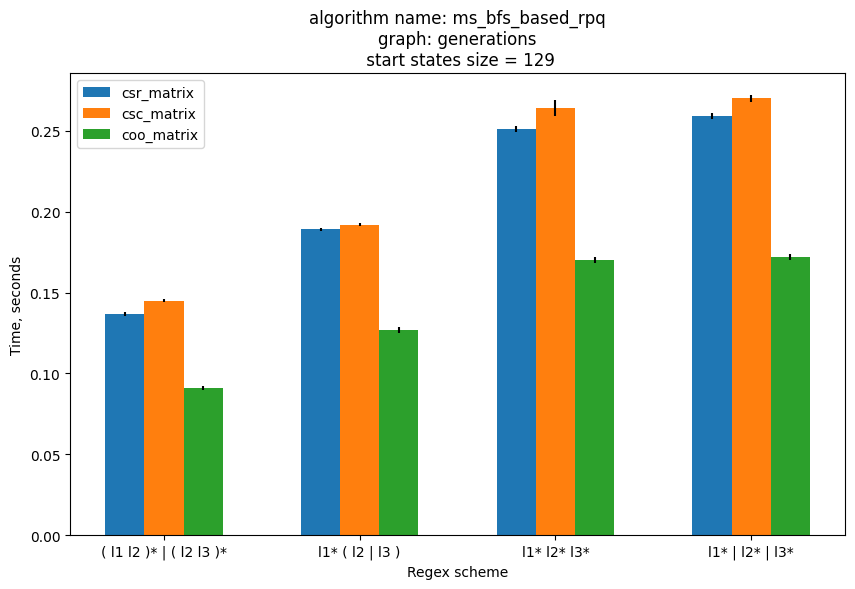

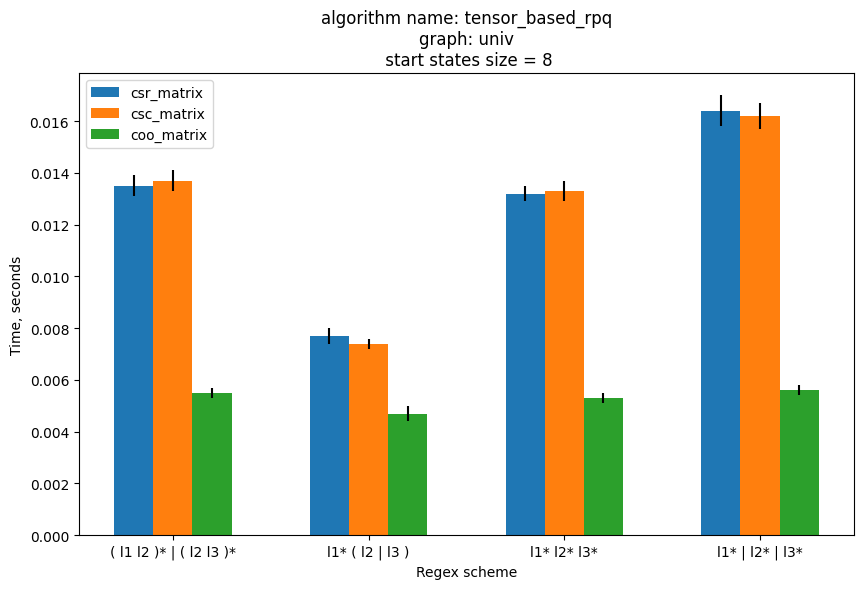

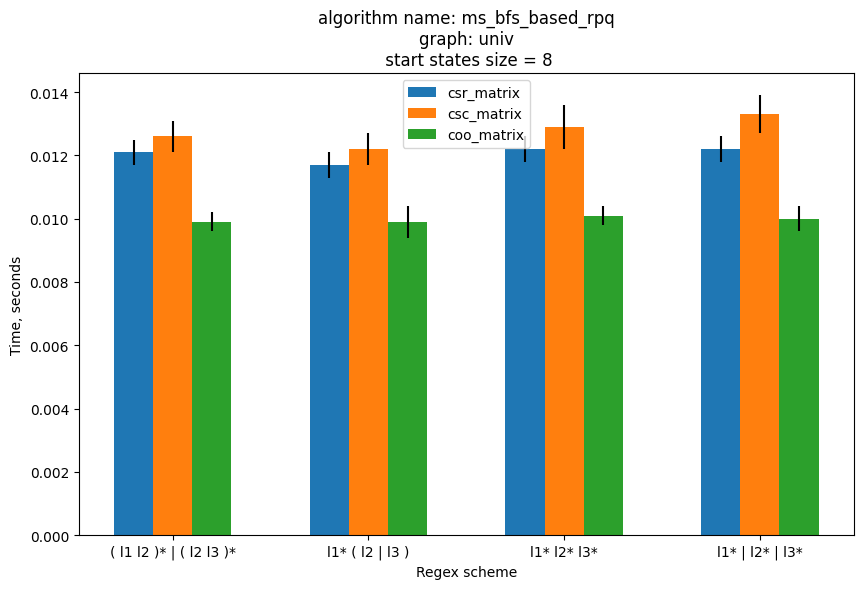

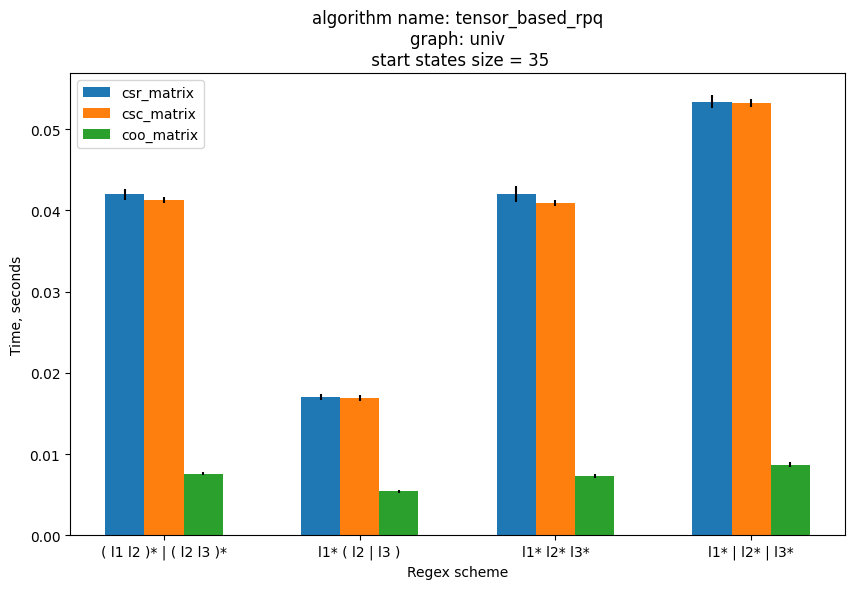

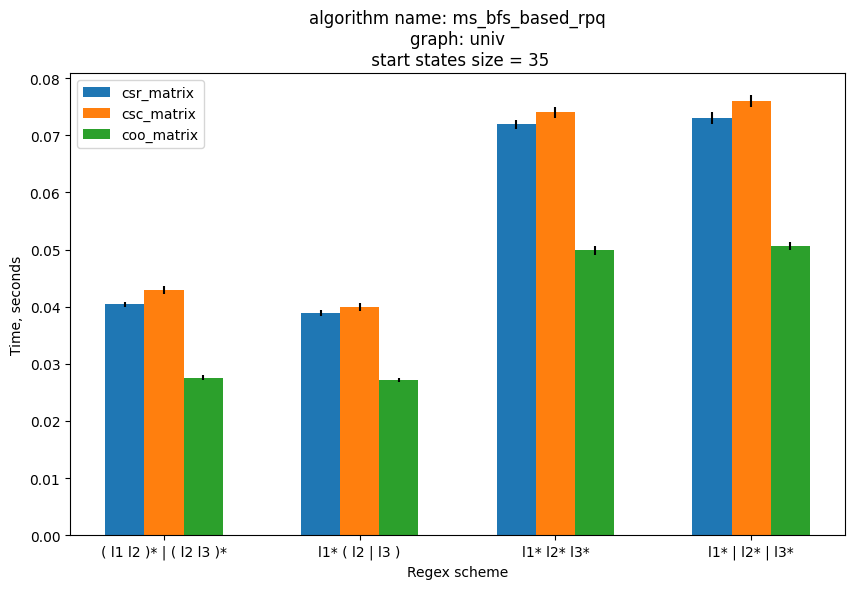

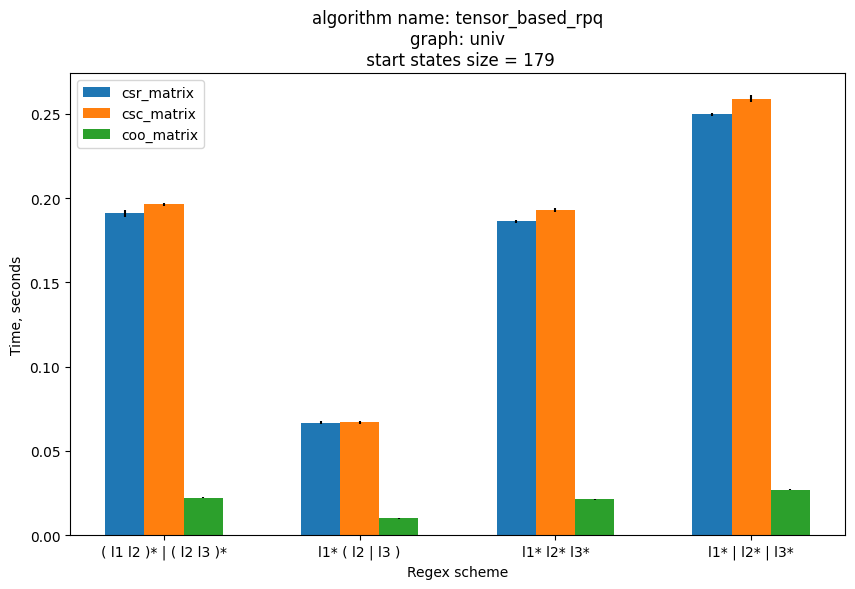

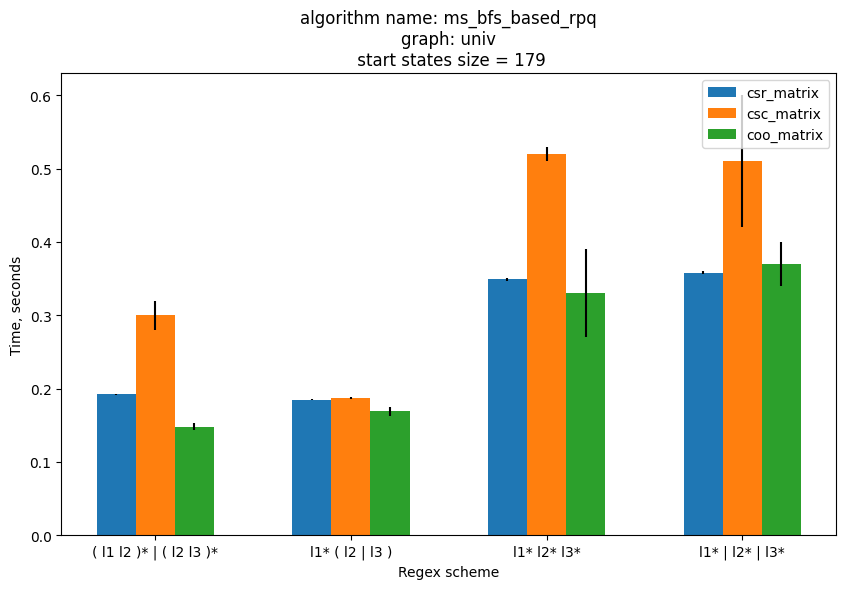

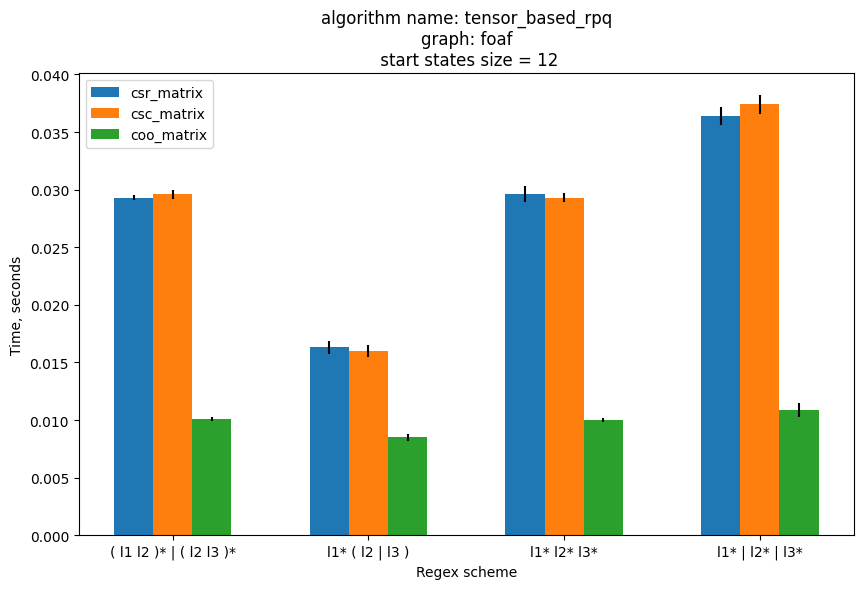

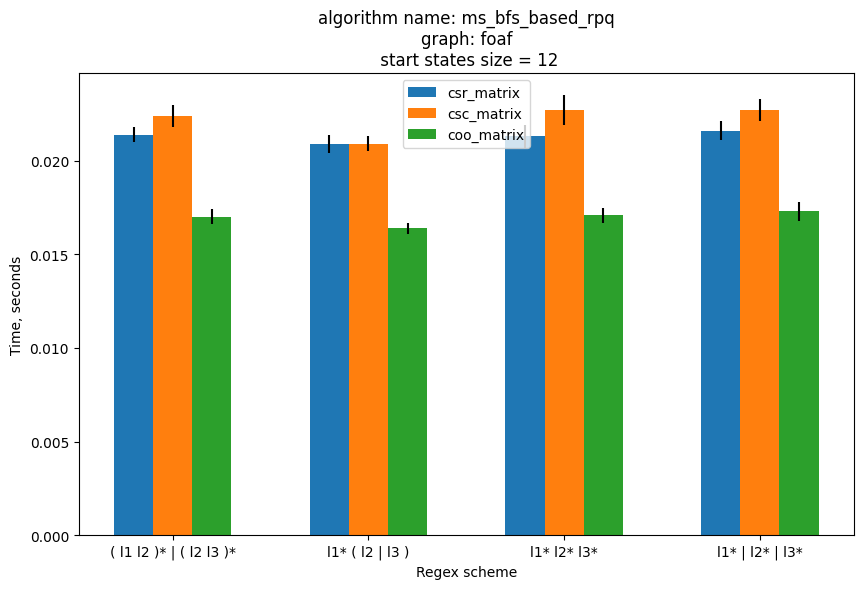

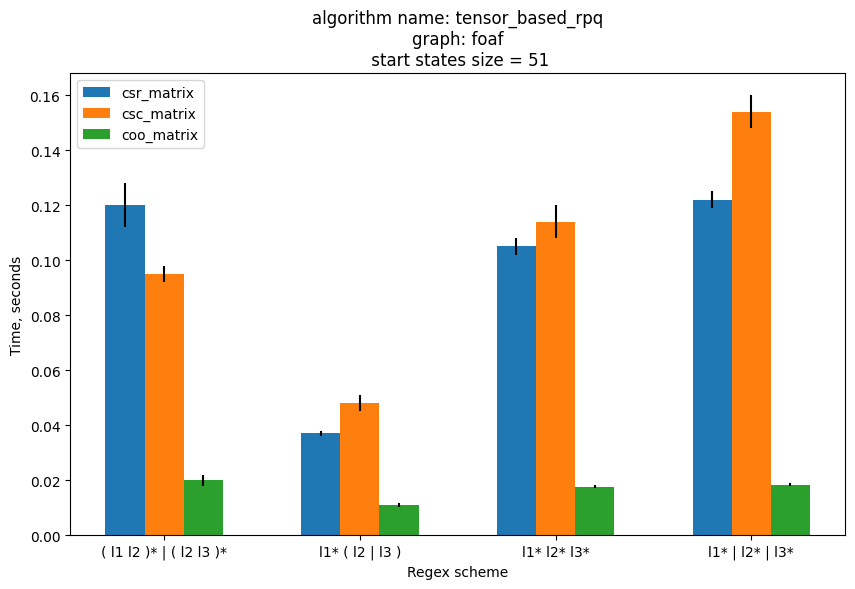

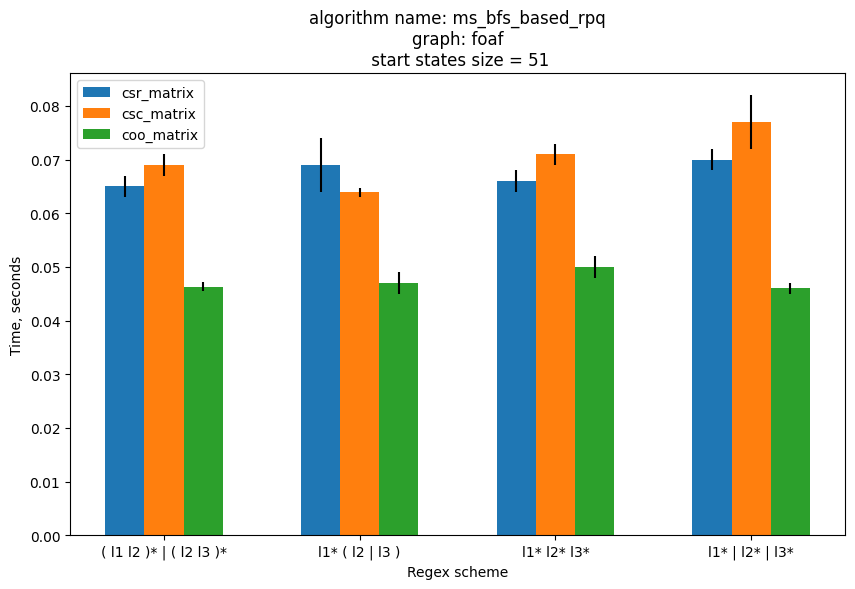

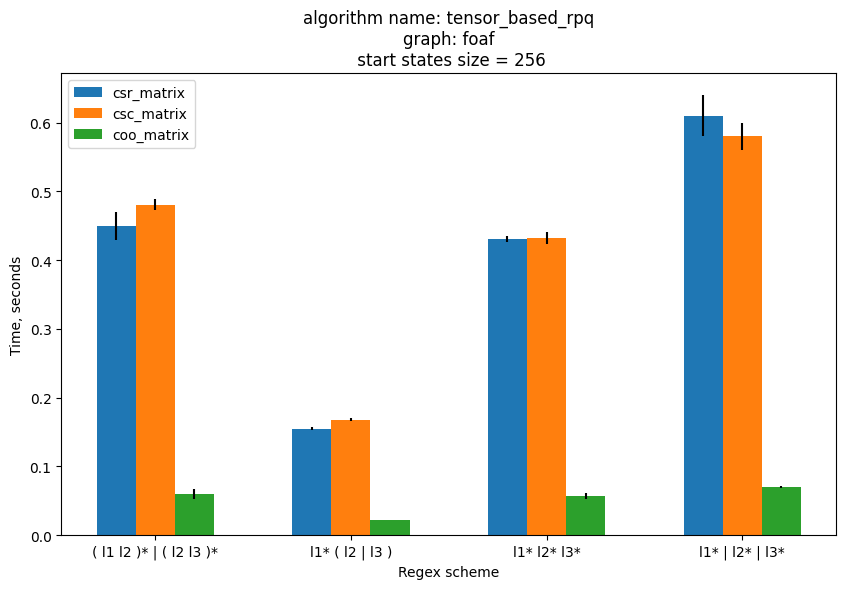

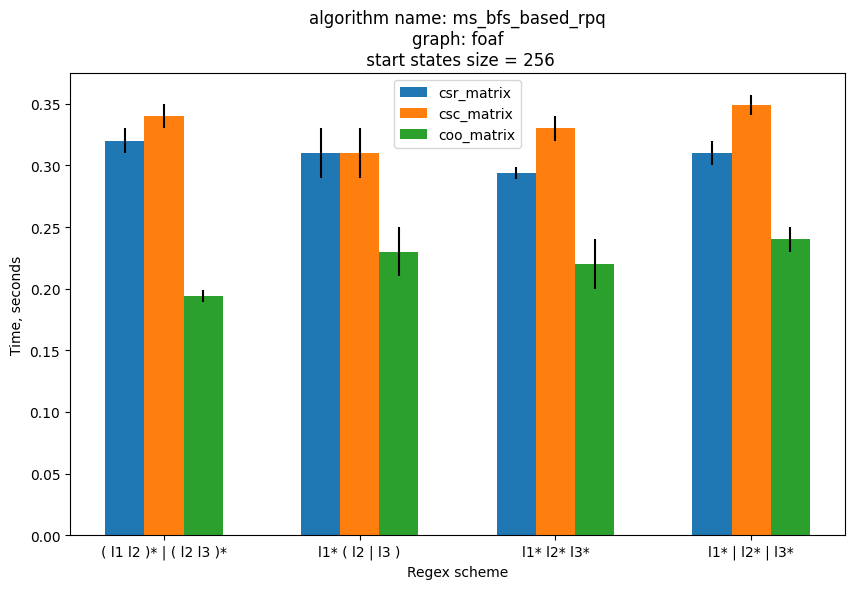

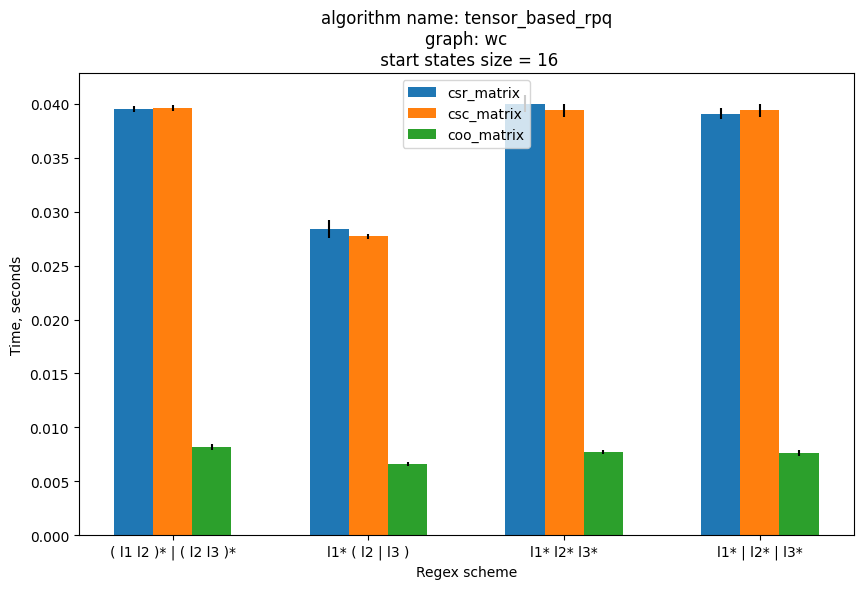

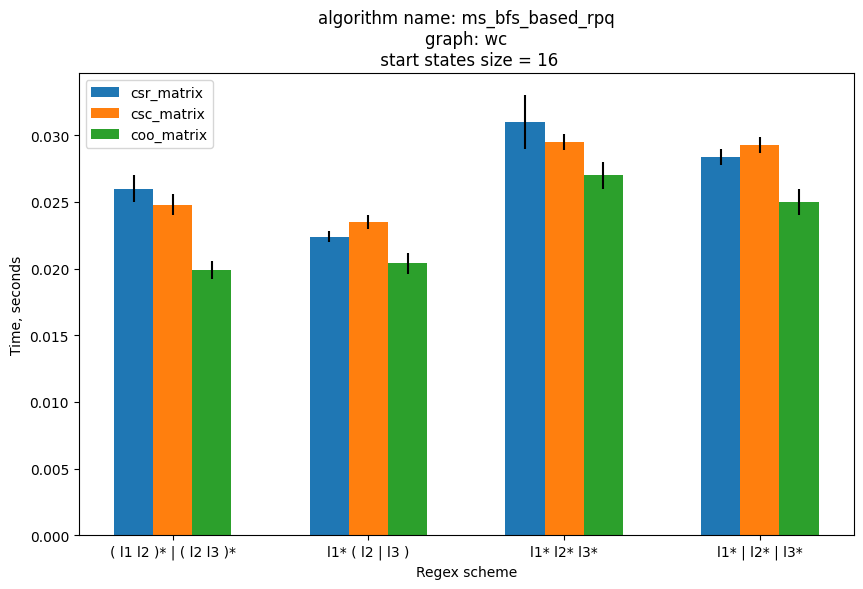

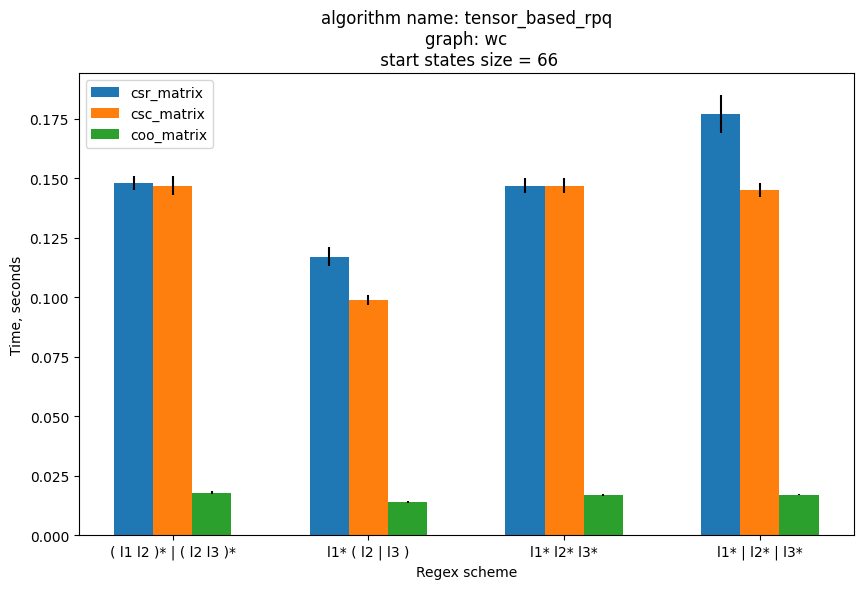

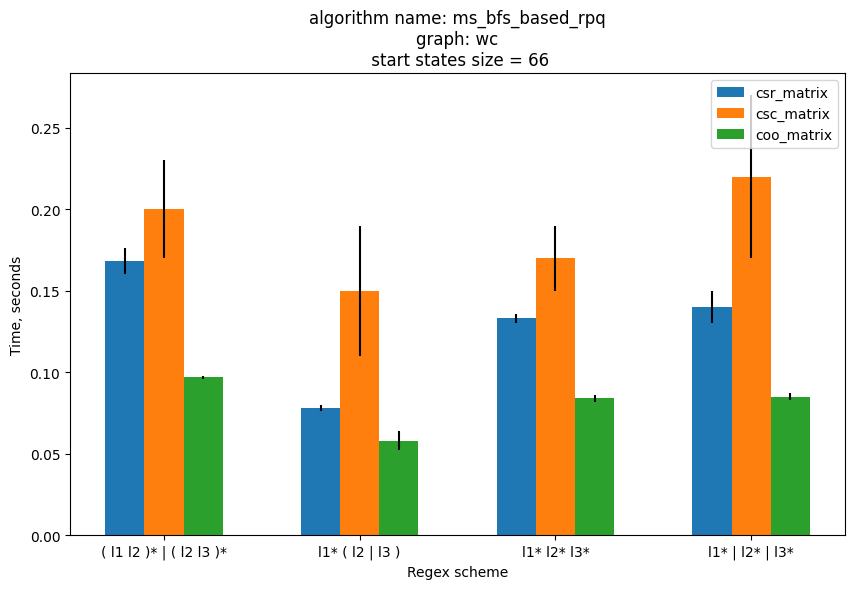

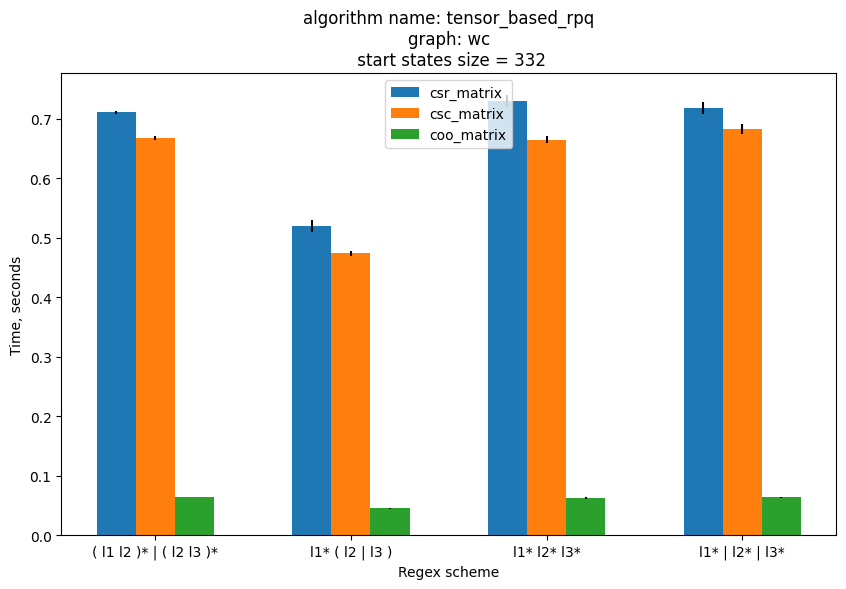

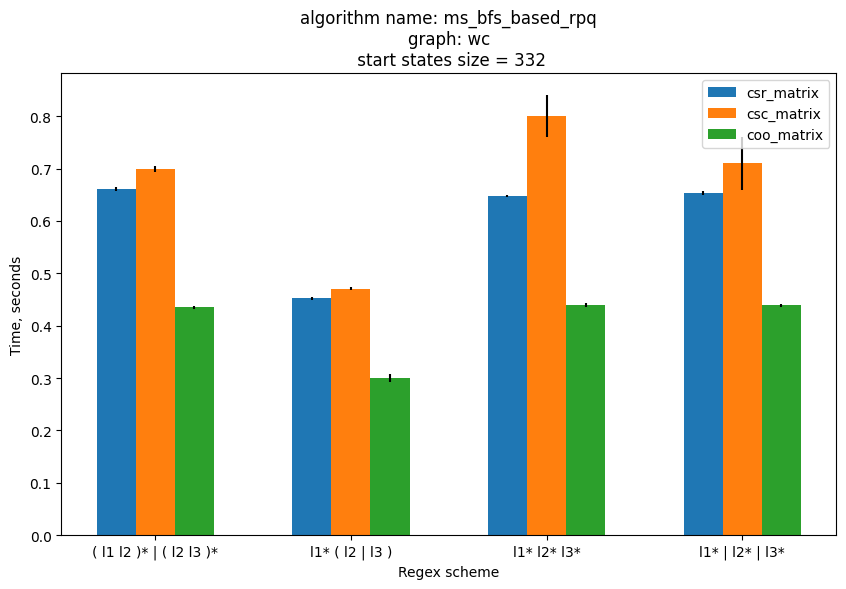

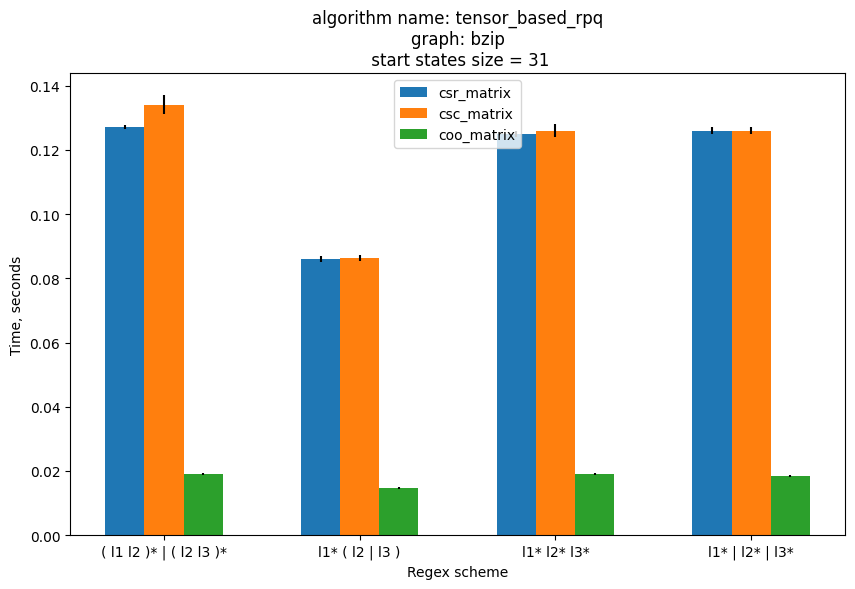

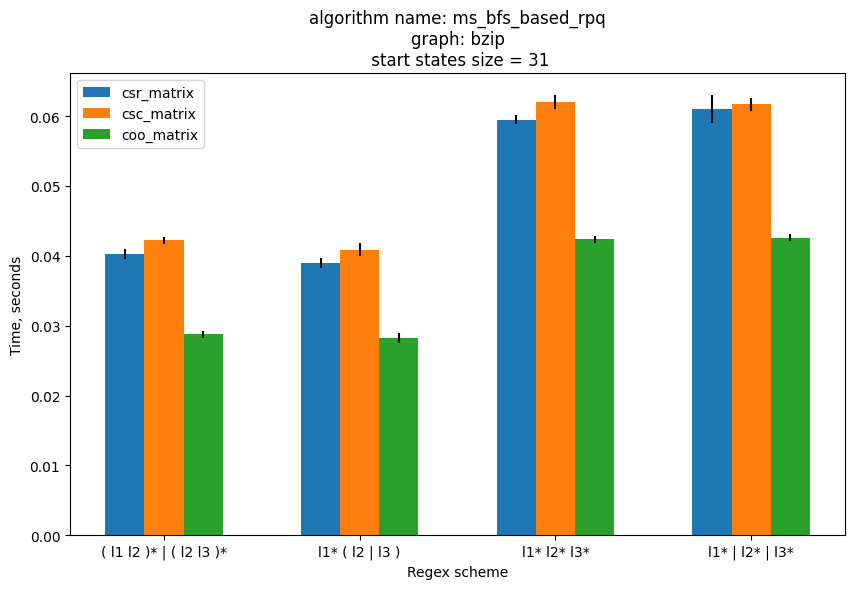

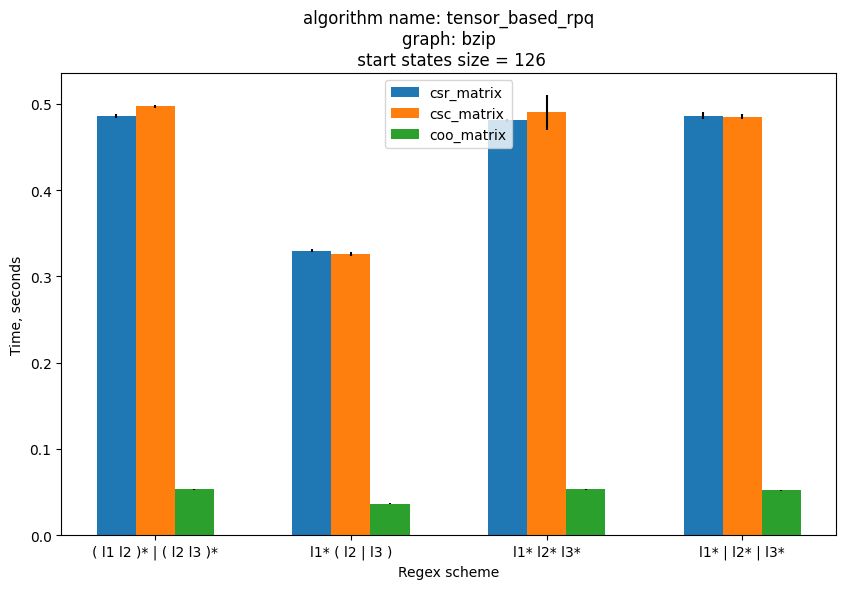

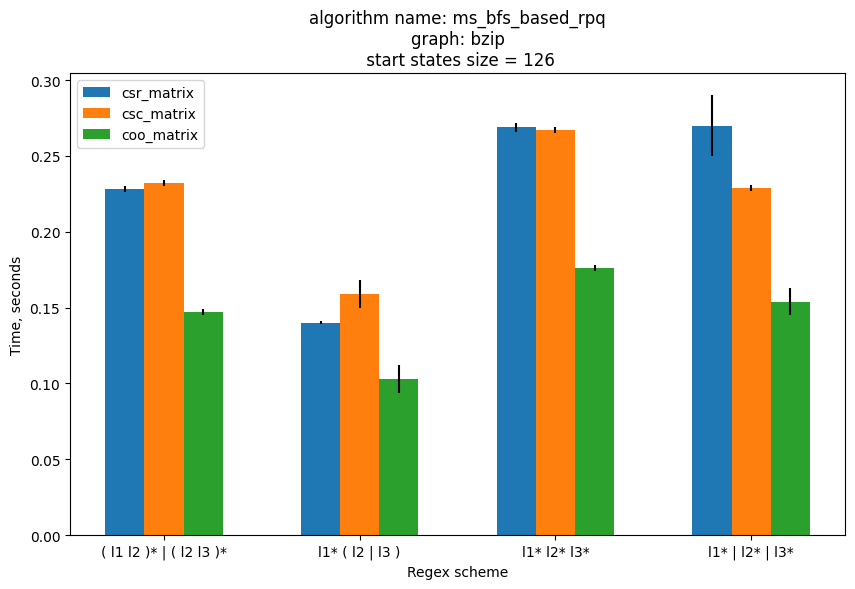

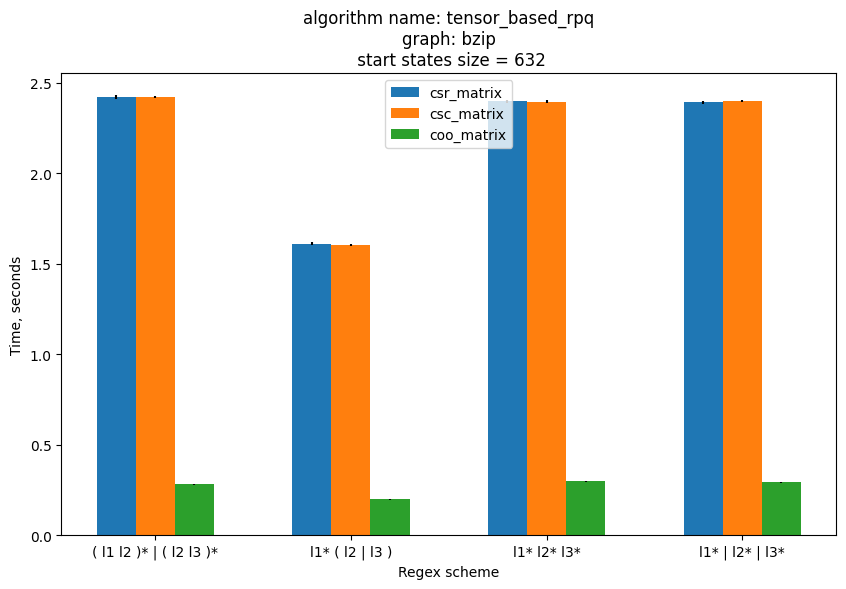

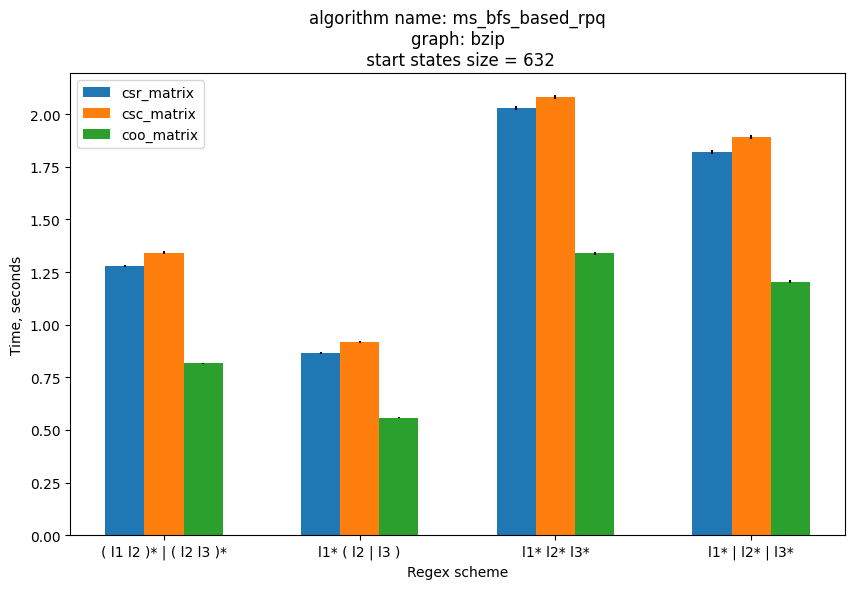

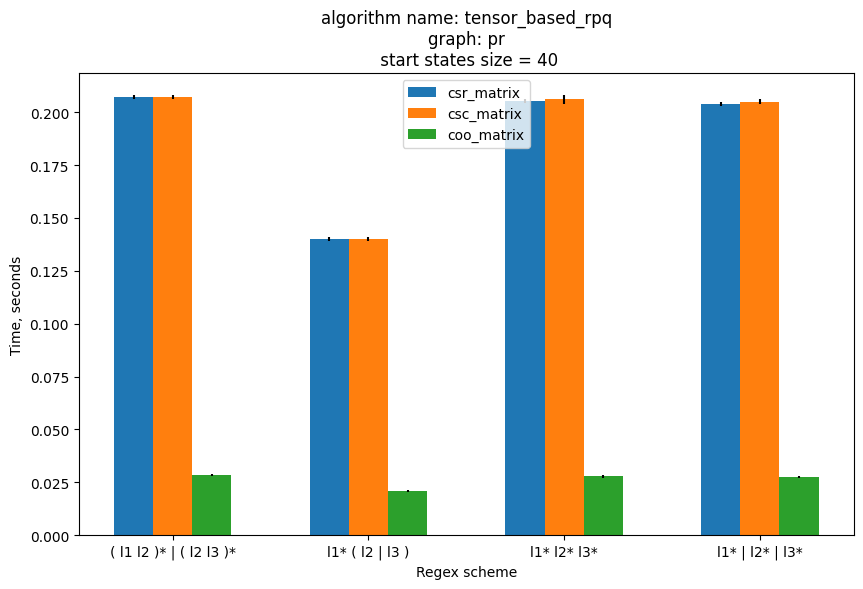

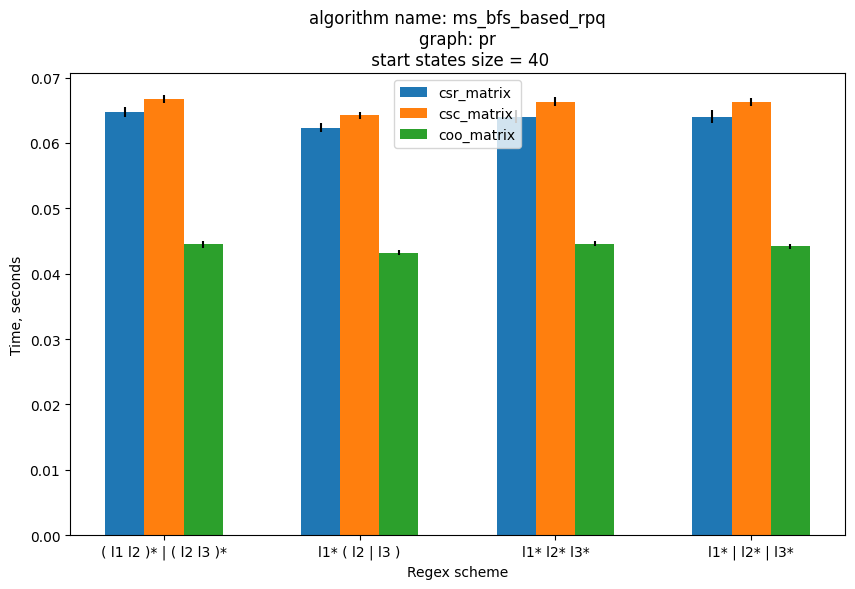

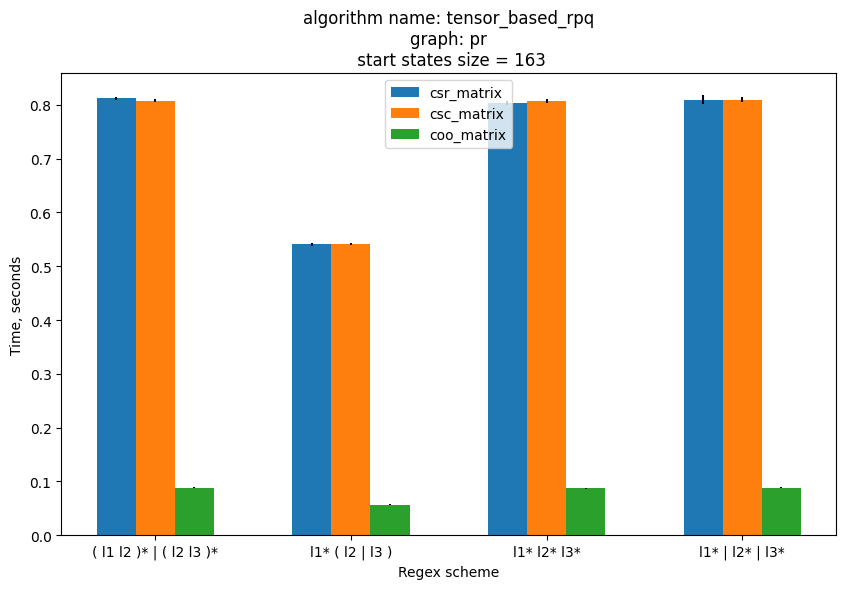

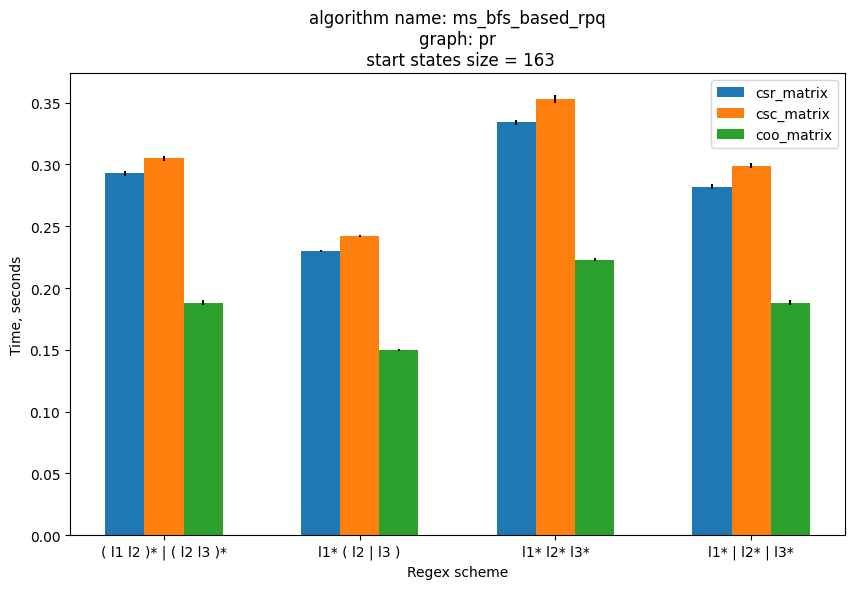

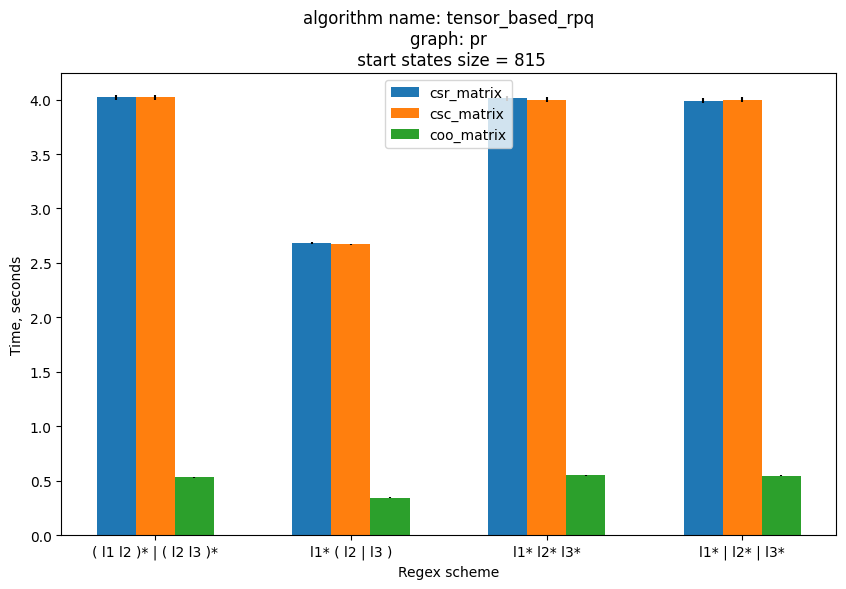

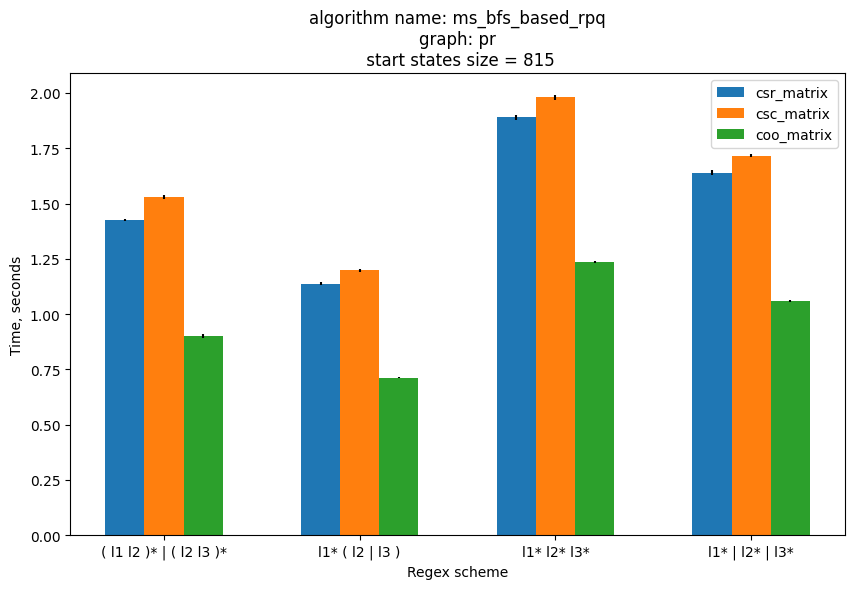

In [11]:
def plot_diff_matrix_results(results):
    grouped_data = defaultdict(lambda: defaultdict(list))

    for result in results:
        key = (result.algorithm_name, result.graph_name, result.start_nodes_number)
        grouped_data[key][result.regex_scheme].append(result)

    for (
        algorithm_name,
        graph_name,
        start_nodes_number,
    ), expr_data in grouped_data.items():
        regex_schemes = sorted(expr_data.keys())

        x = np.arange(len(regex_schemes))
        width = 0.2
        _, ax = plt.subplots(figsize=(10, 6))

        for i, matrix_type in enumerate(SPARSE_MATRICES_TYPES_NAMES):
            times = []
            errors = []
            for regex in regex_schemes:
                found = False
                for res in expr_data[regex]:
                    if res.sparse_matrix_type == matrix_type:
                        times.append(float(res.mean_time))
                        errors.append(float(res.std_time))
                        found = True
                        break
                if not found:
                    times.append(0.0)
            ax.bar(x + i * width, times, width, label=matrix_type, yerr=errors)

        ax.set_xlabel("Regex scheme")
        ax.set_ylabel("Time, seconds")
        ax.set_title(
            f"algorithm name: {algorithm_name}\ngraph: {graph_name}\n start states size = {start_nodes_number}"
        )
        ax.set_xticks(x + width * (len(SPARSE_MATRICES_TYPES_NAMES) - 1) / 2)
        ax.set_xticklabels(regex_schemes)
        ax.legend()
        plt.show()


plot_diff_matrix_results(results)

## 2. Размер стартового множества, начиная с которго выгоднее решать задачу для всех пар и выбирать нужные ##

При проведении эксперимента запуски будут проводиться на различных графах, различном количестве стартовых вершин, различных регулярных выражениях и представлениях разреженных матриц. 

Спойлер: результаты прошлого пункта эксперимента показали, что алгоритмы эффективнее работают на `coo_matrix`, поэтому важно при проведении этого эксперимента также запуститься на разных представлениях разреженных матриц (а не только на том, который используется в дефолтной реализации алгоритма).


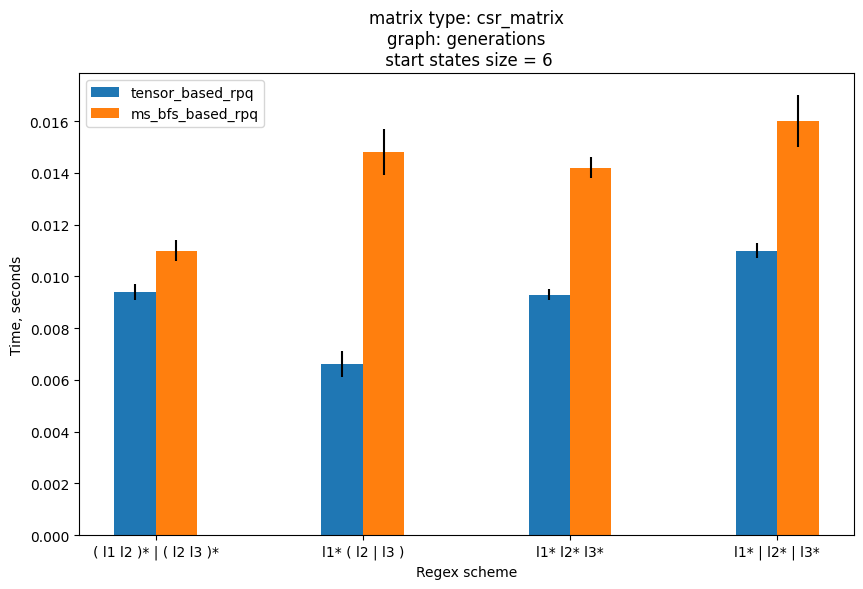

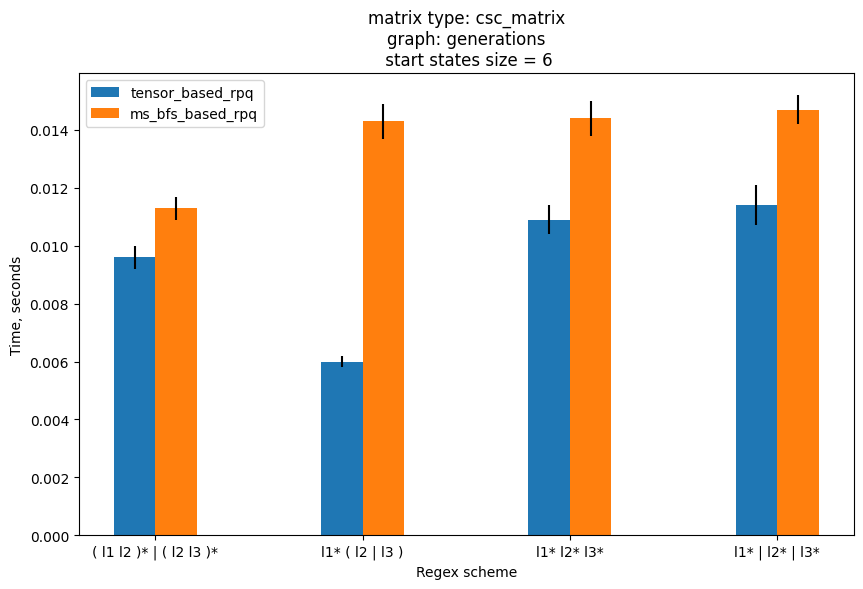

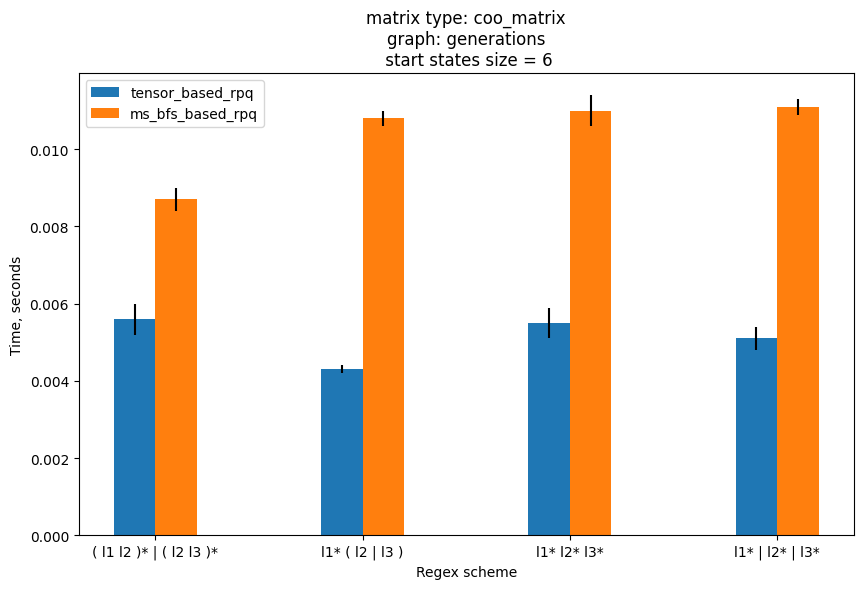

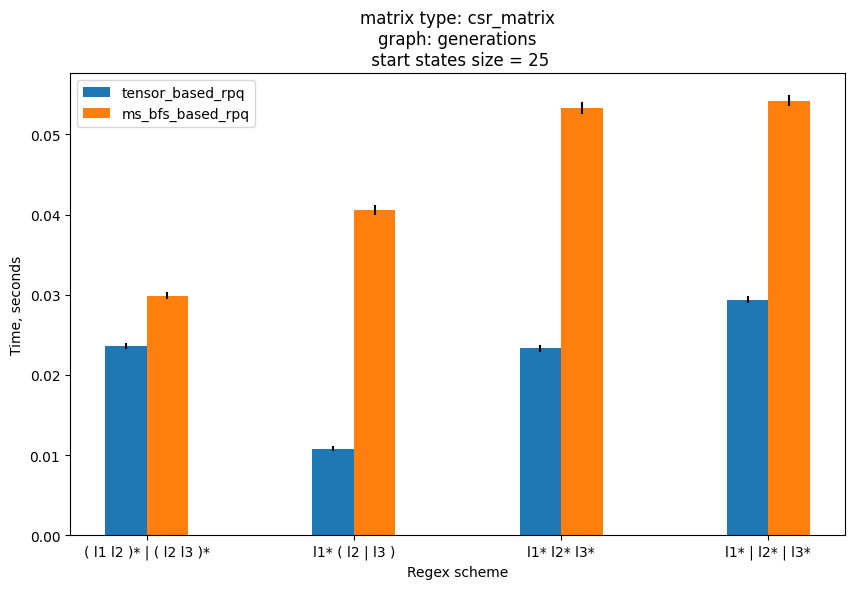

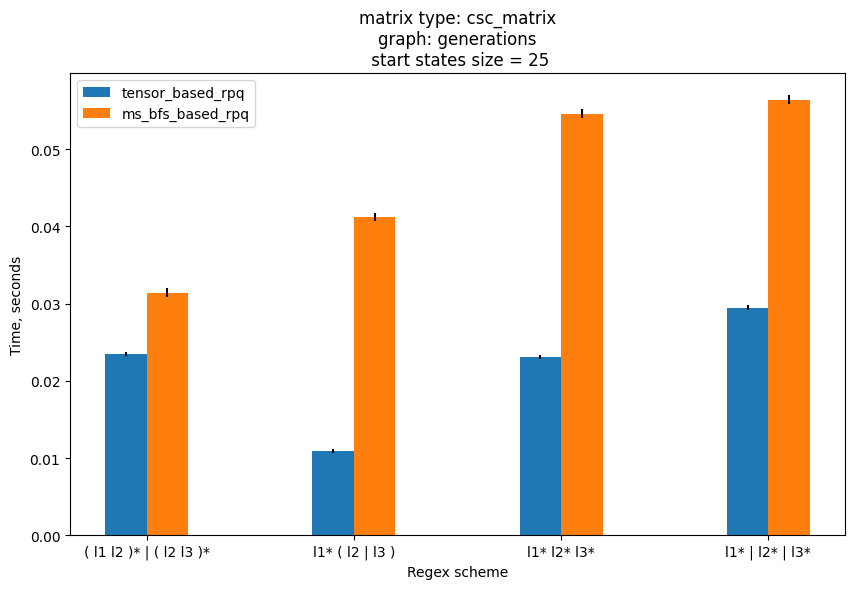

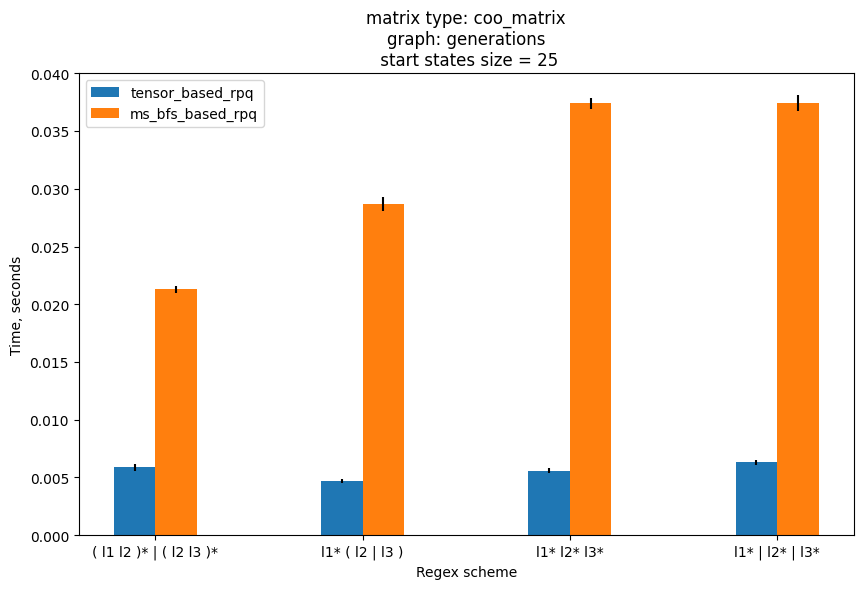

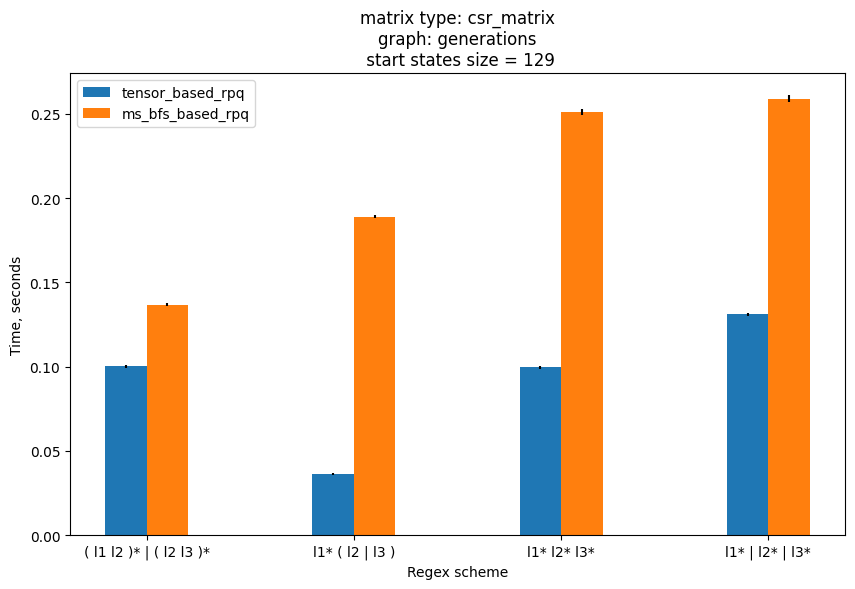

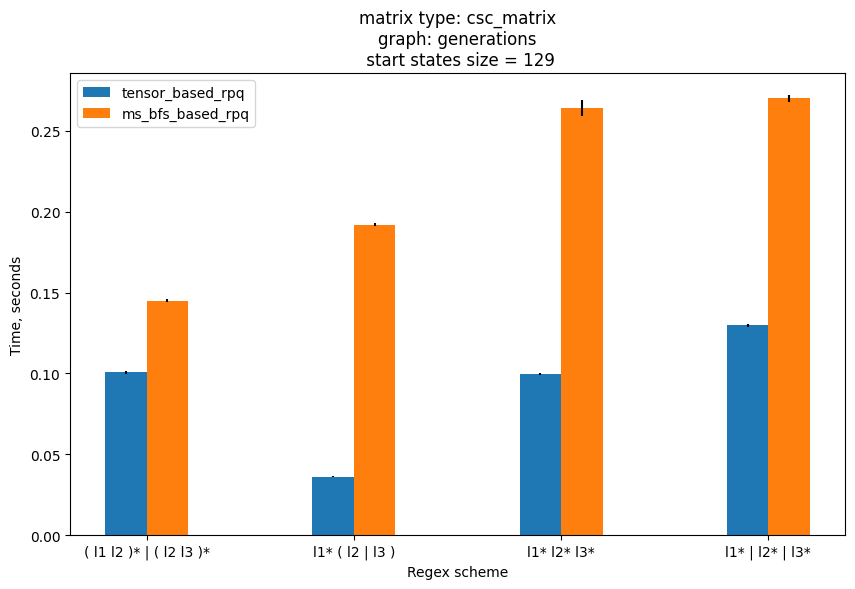

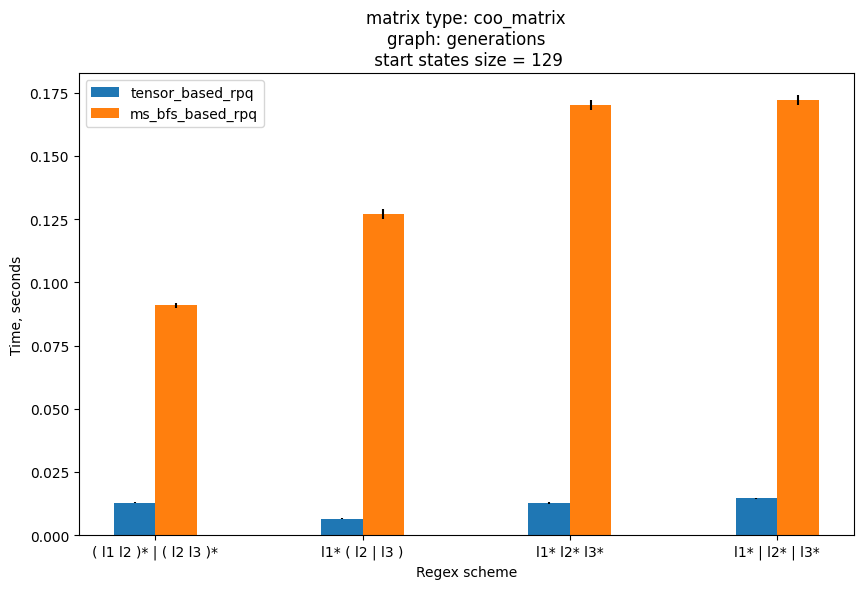

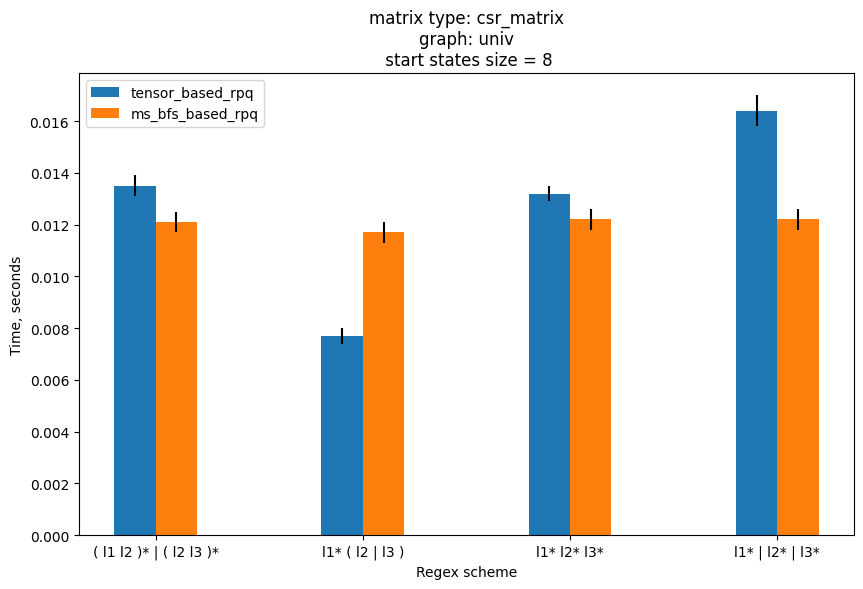

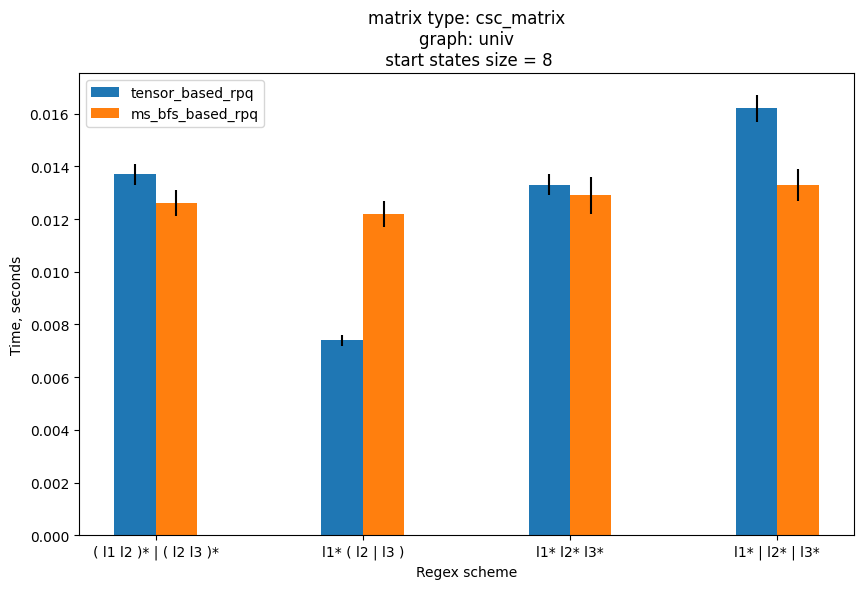

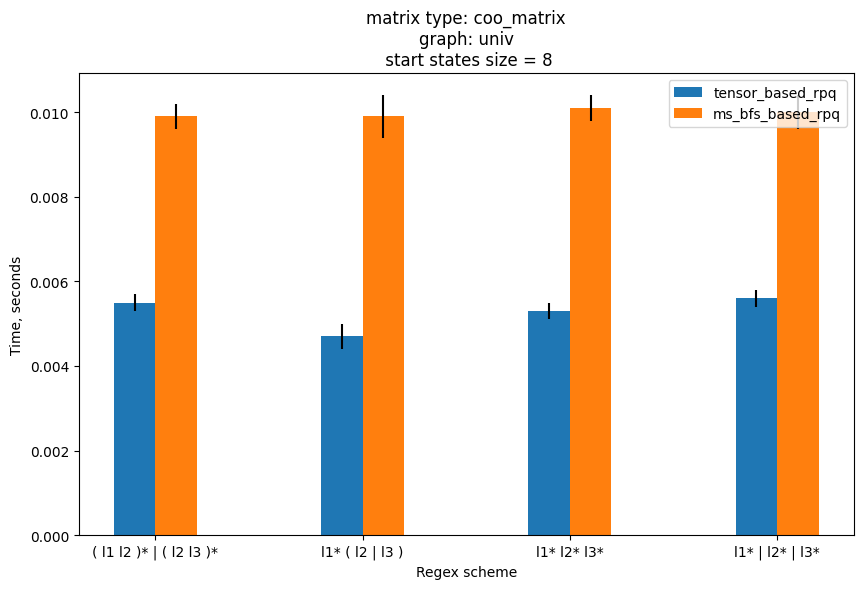

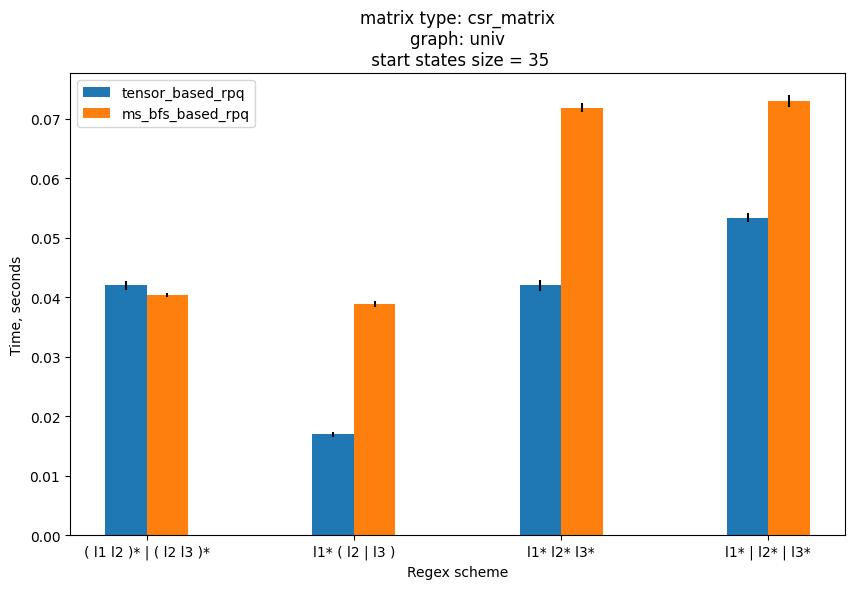

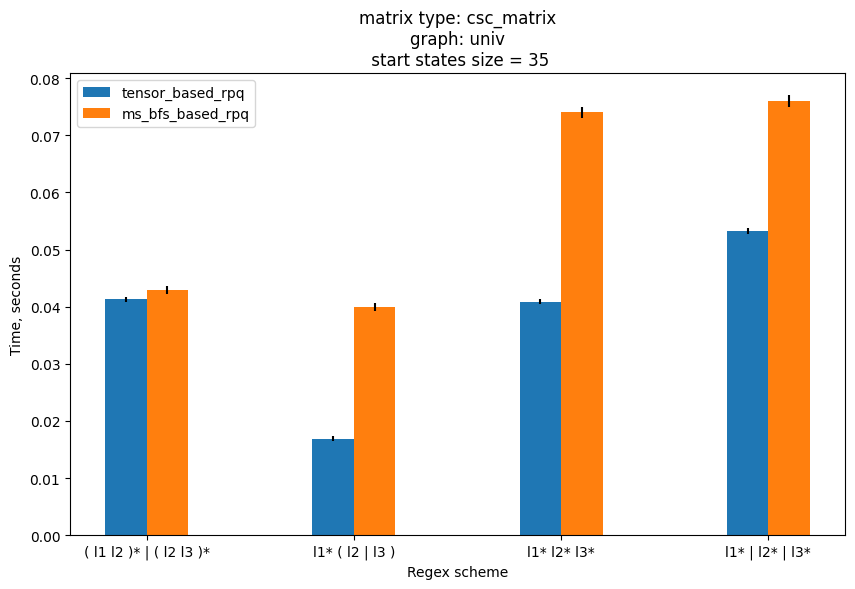

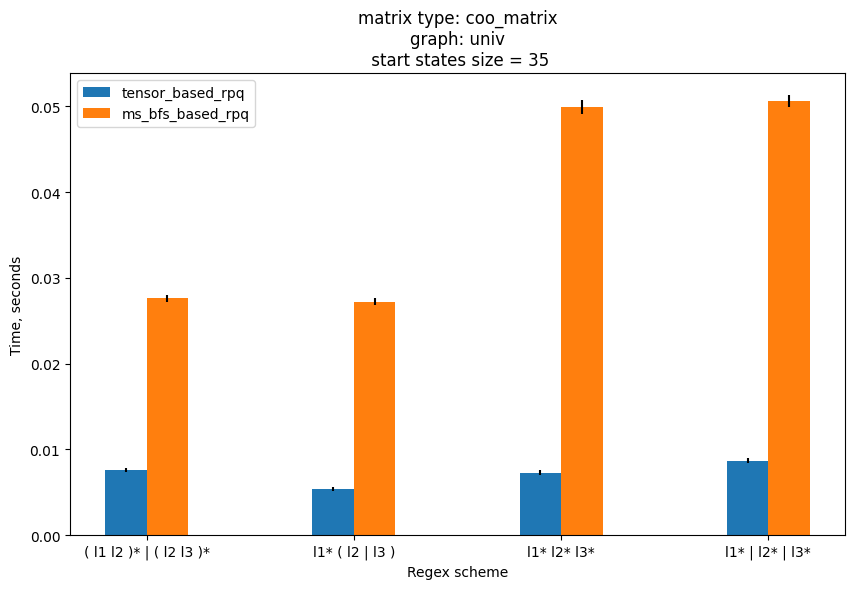

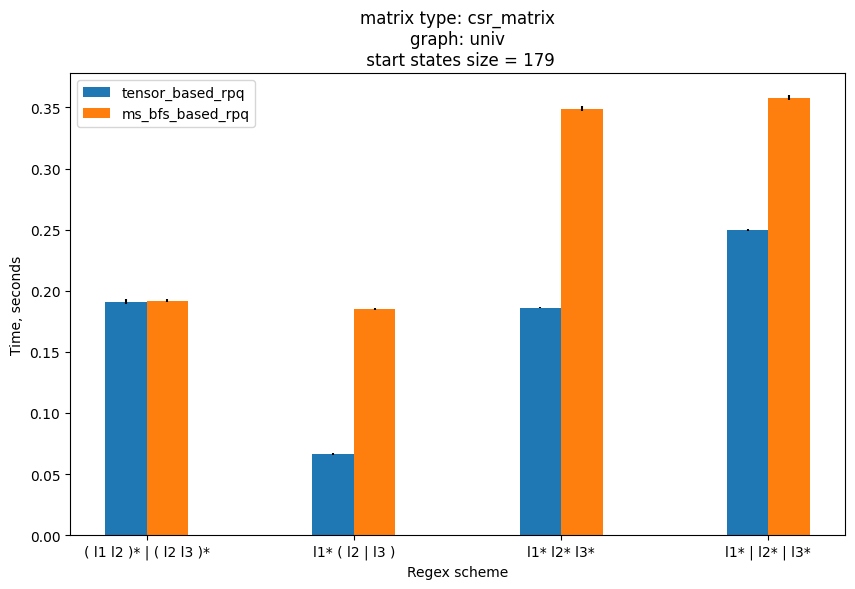

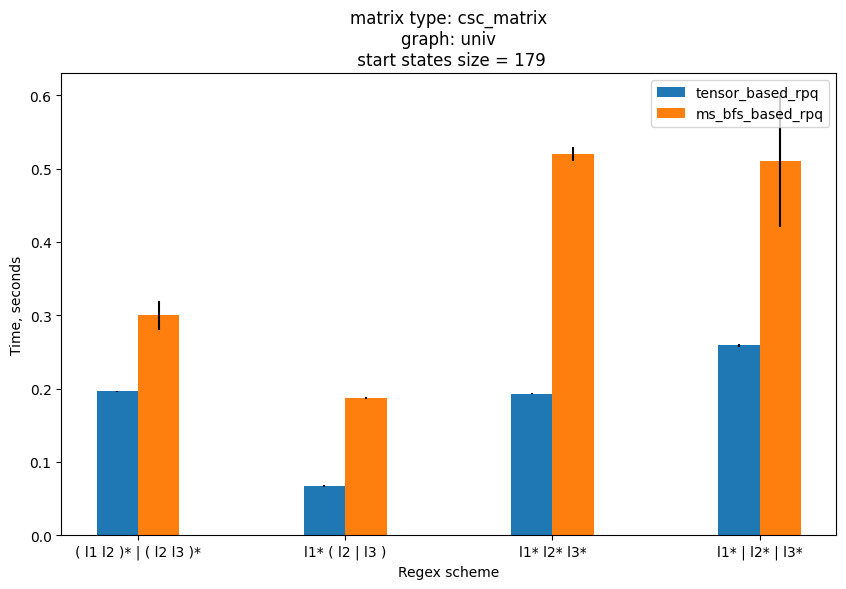

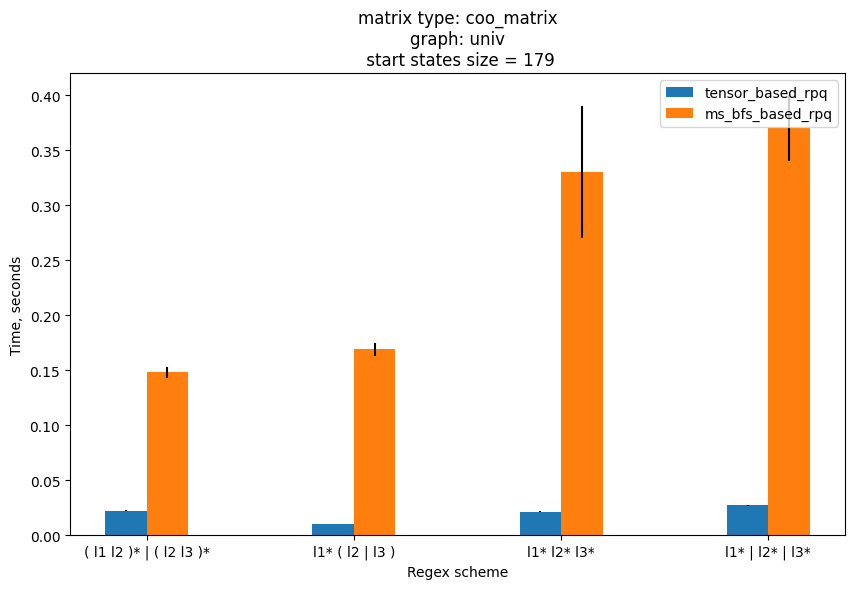

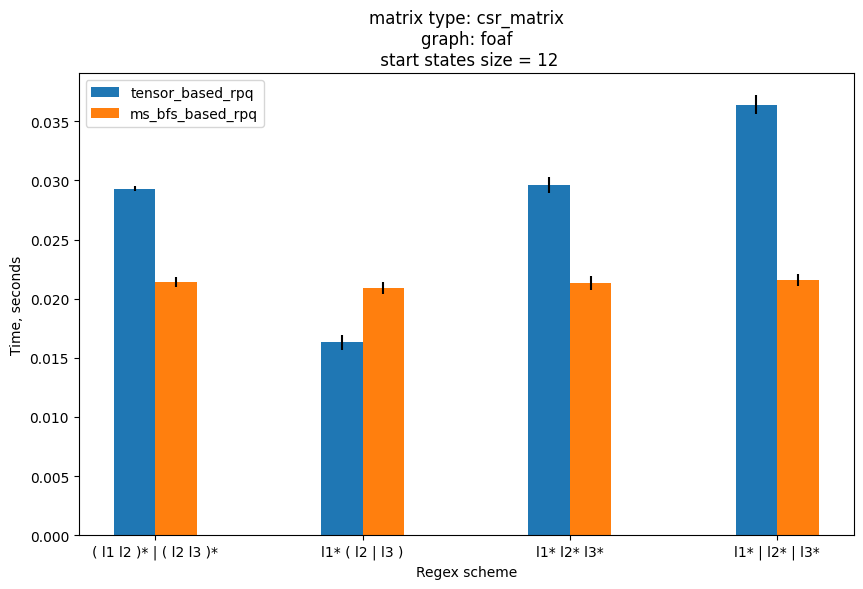

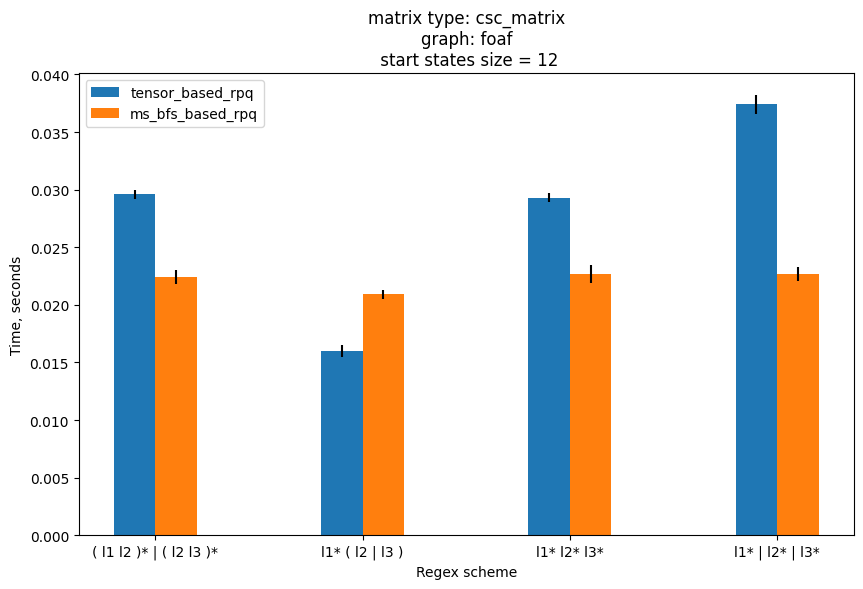

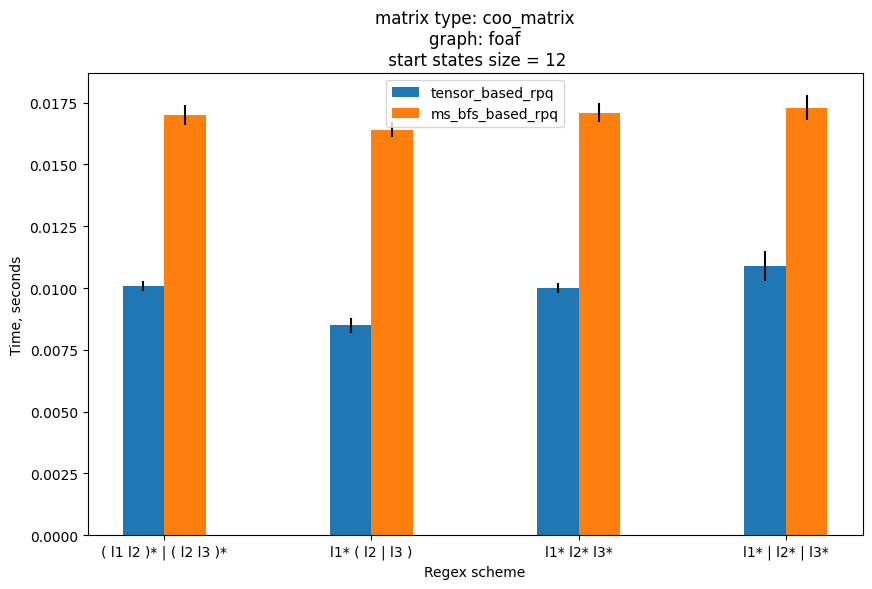

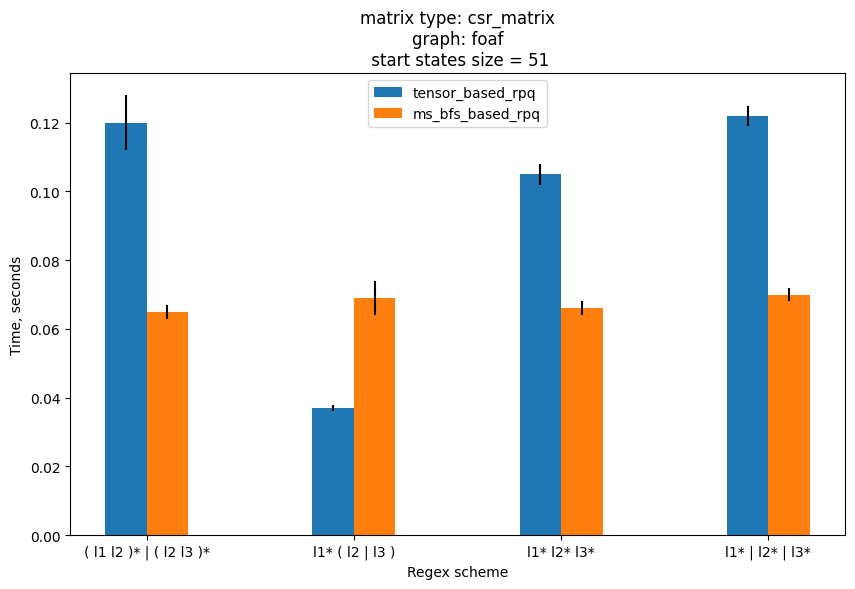

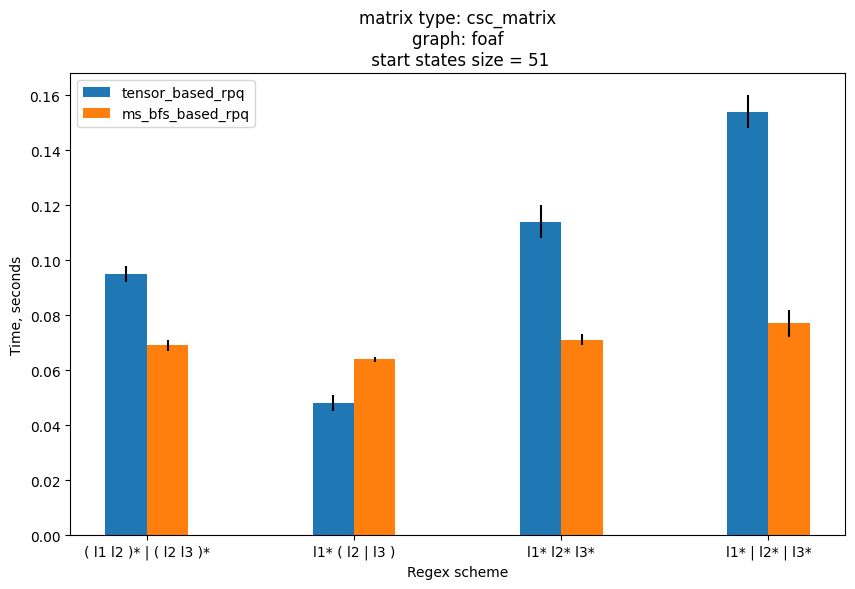

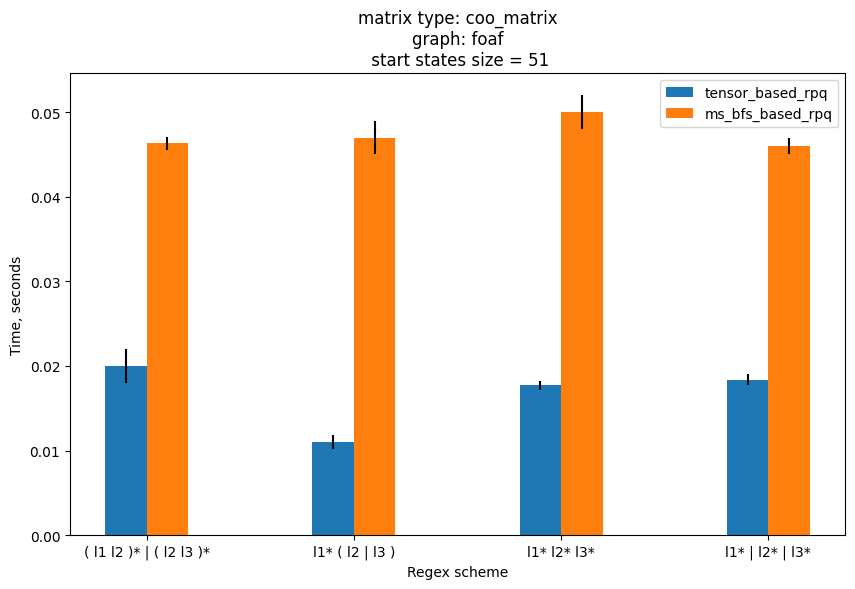

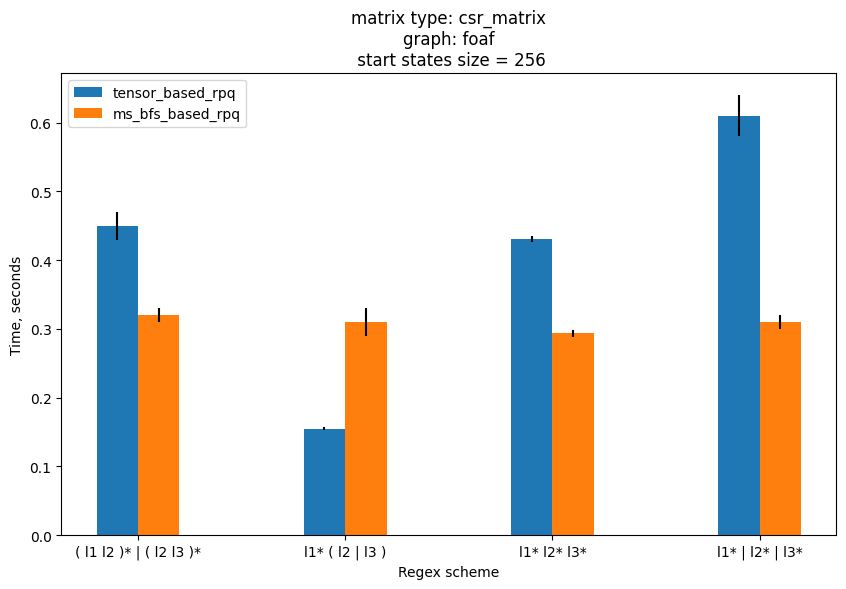

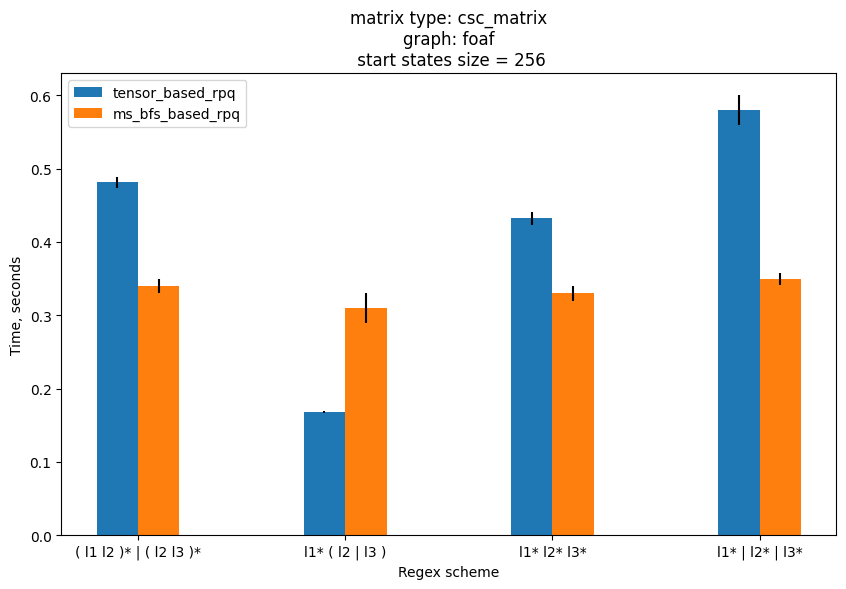

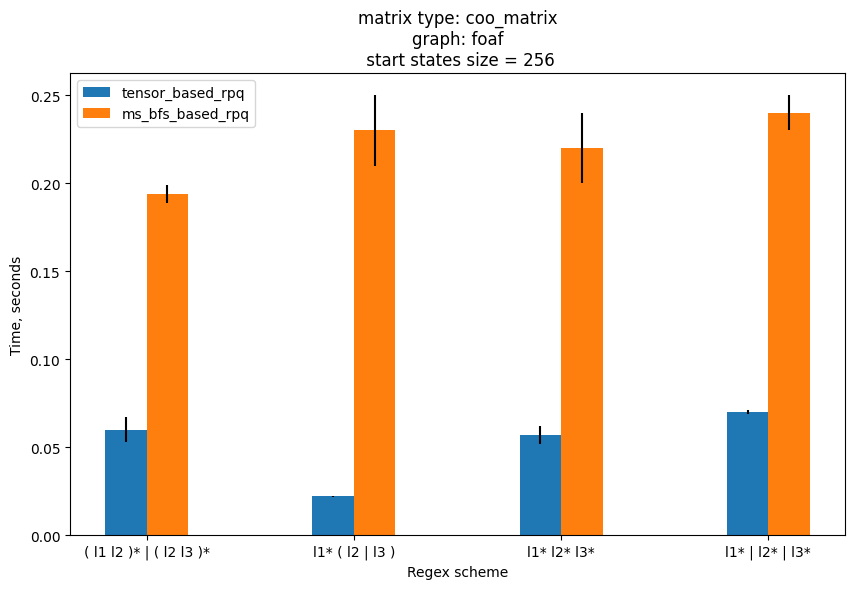

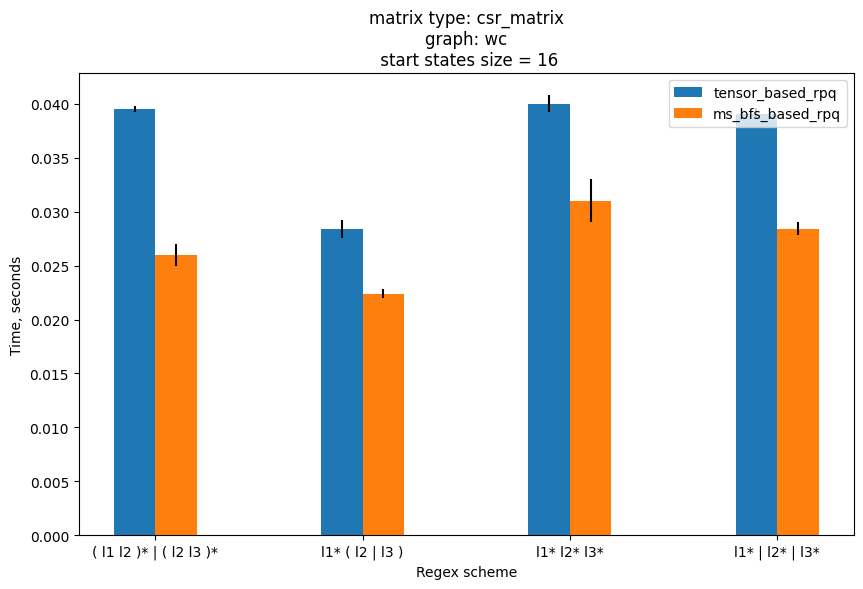

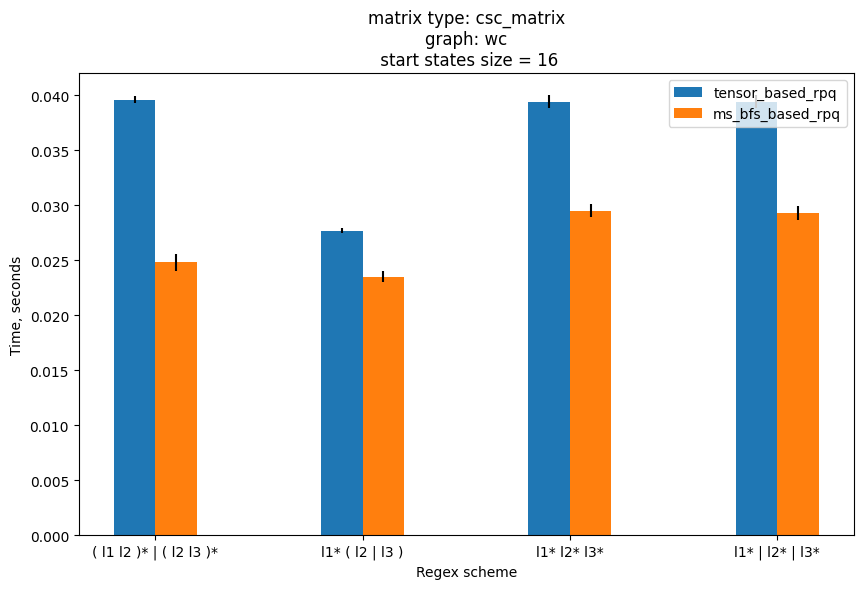

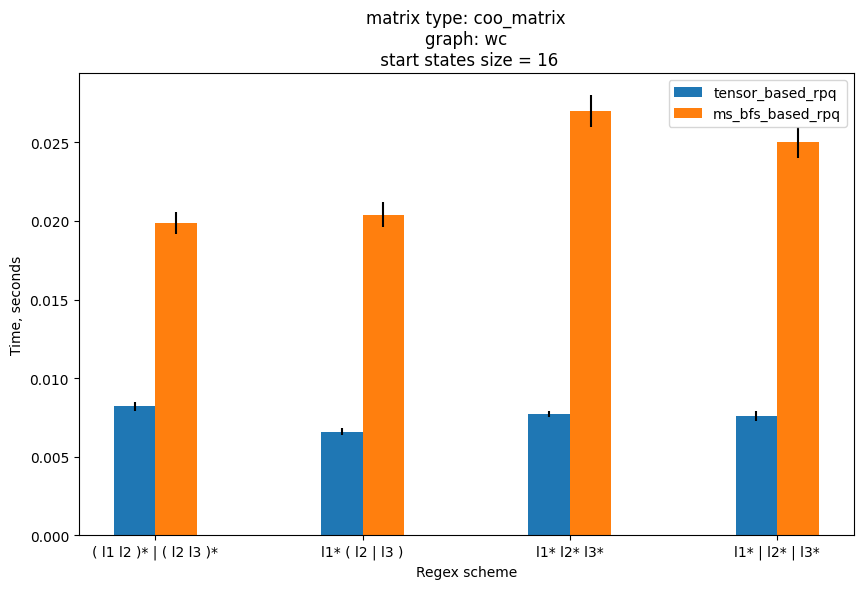

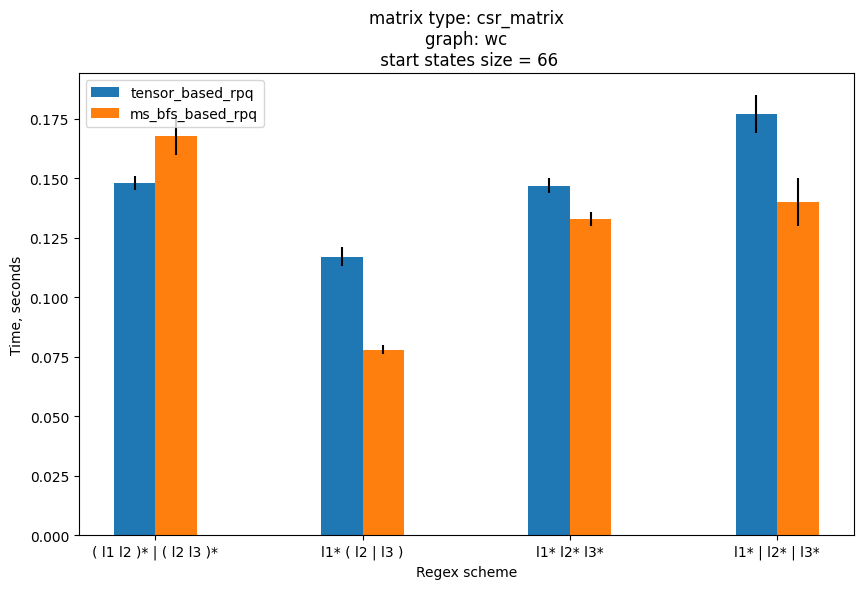

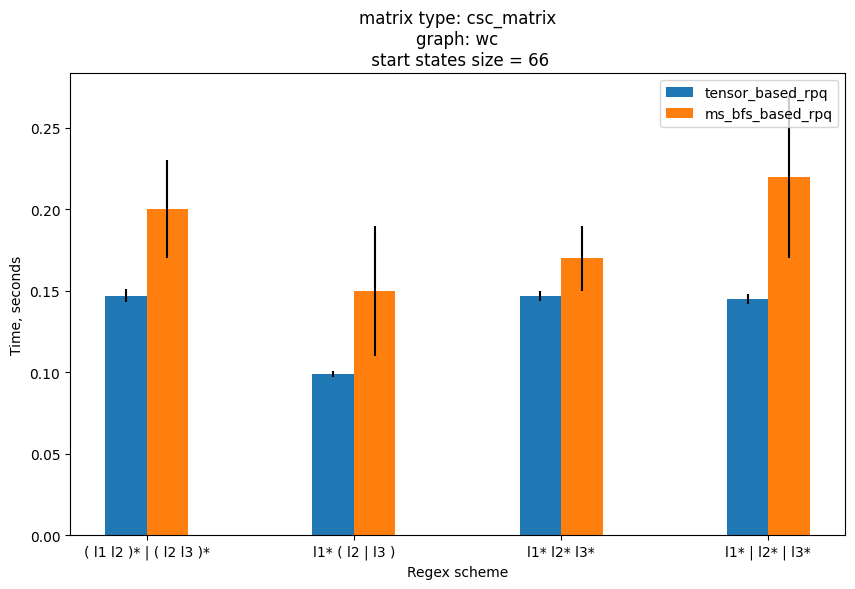

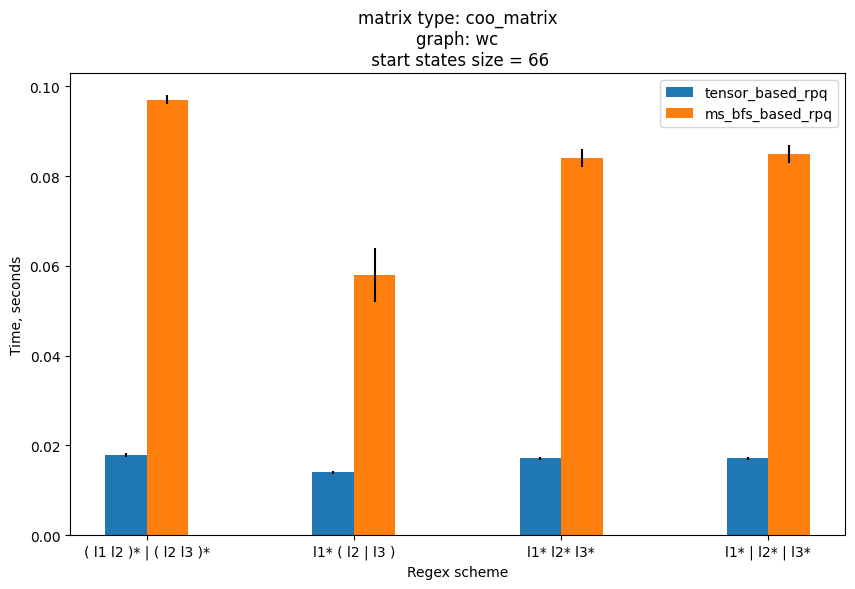

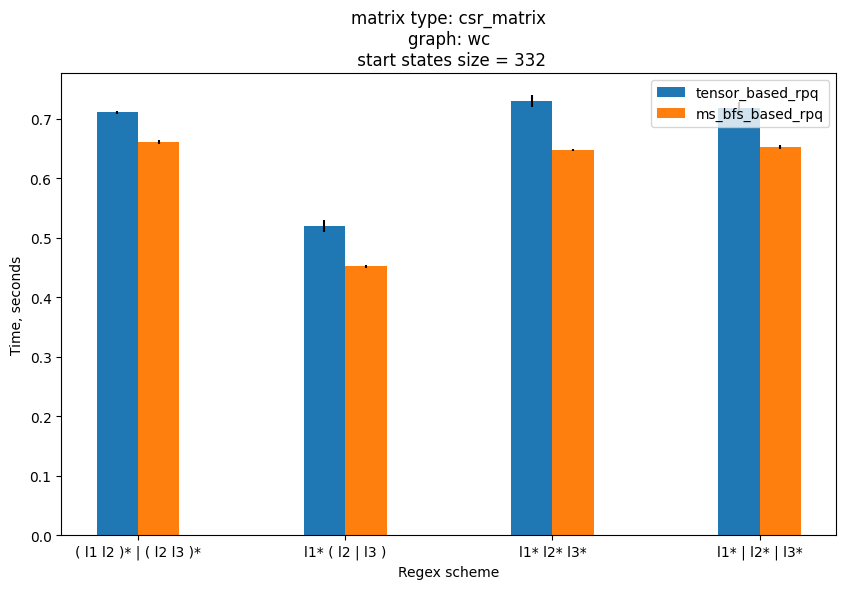

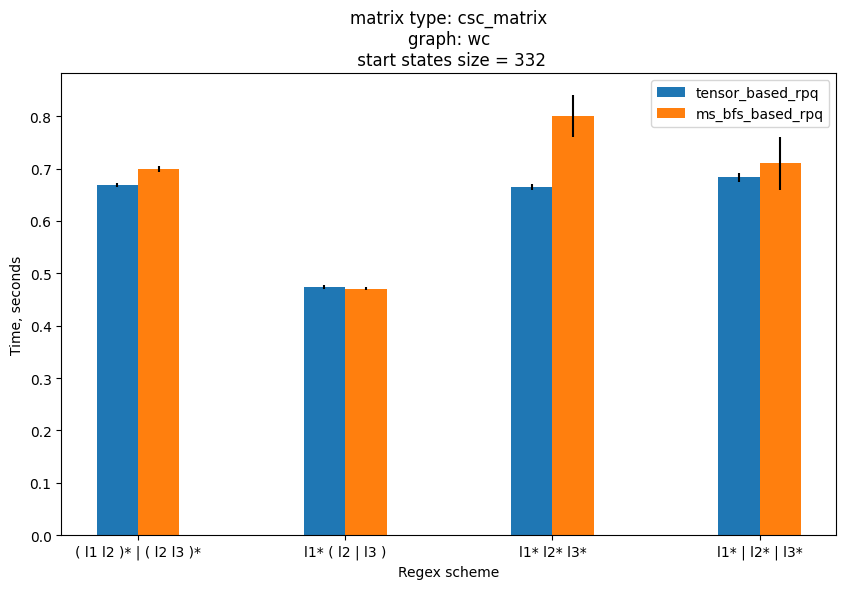

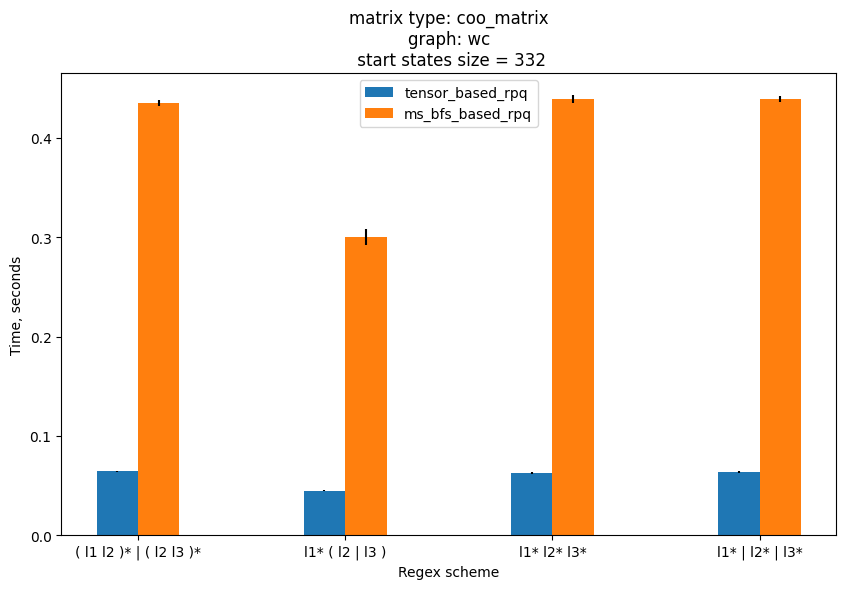

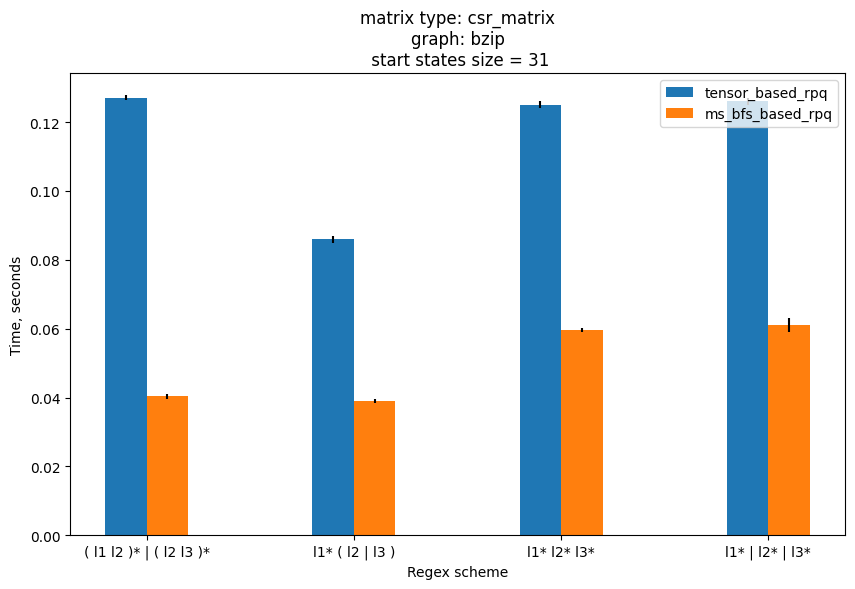

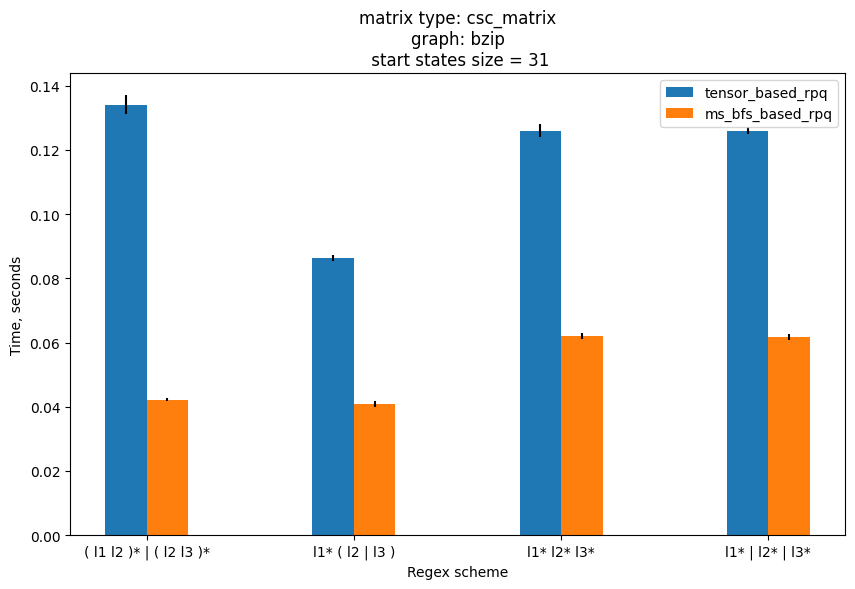

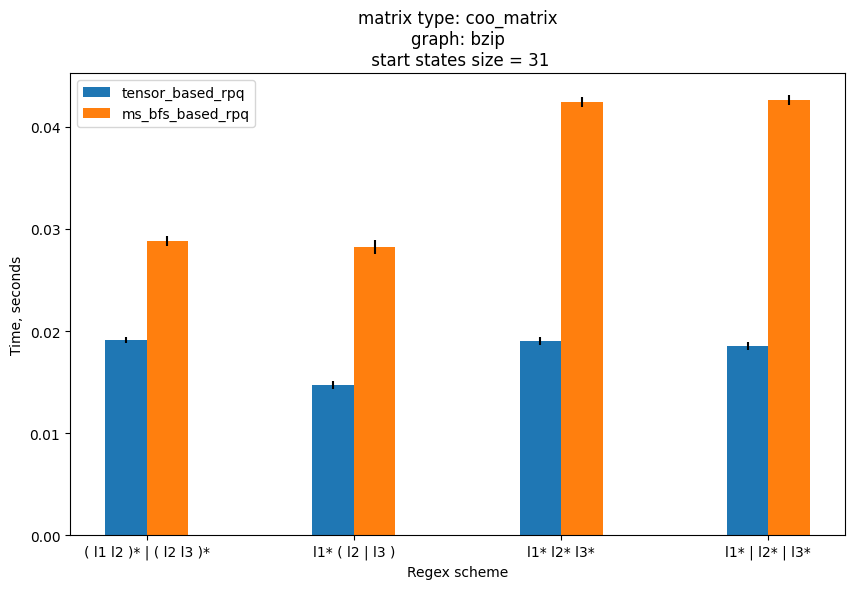

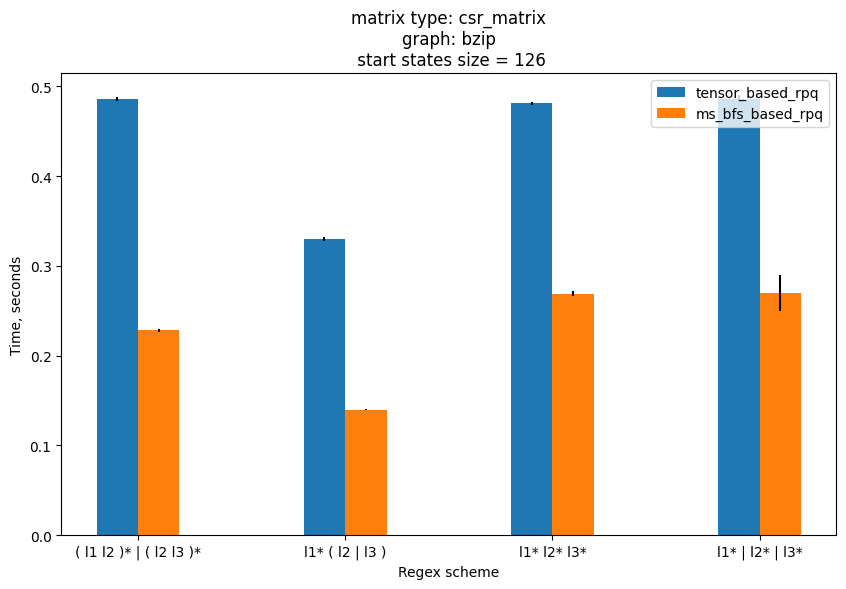

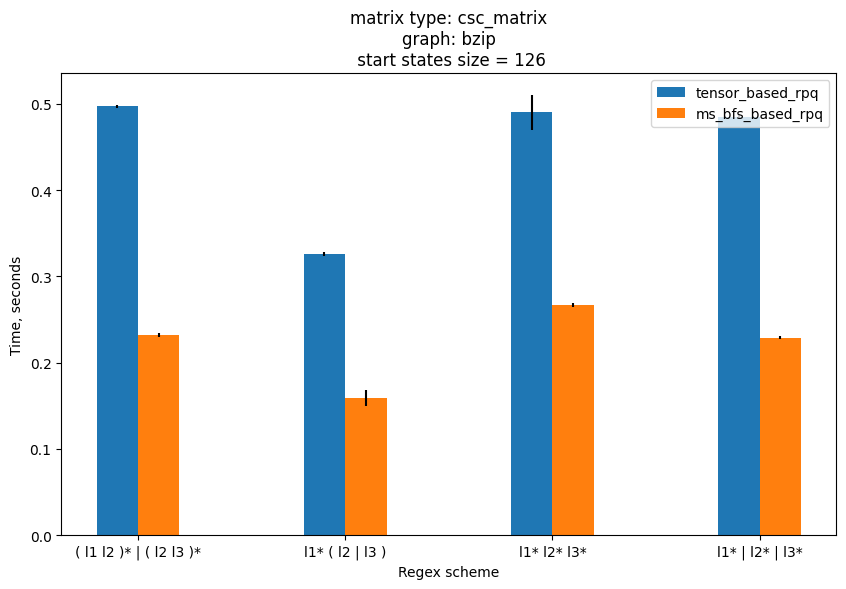

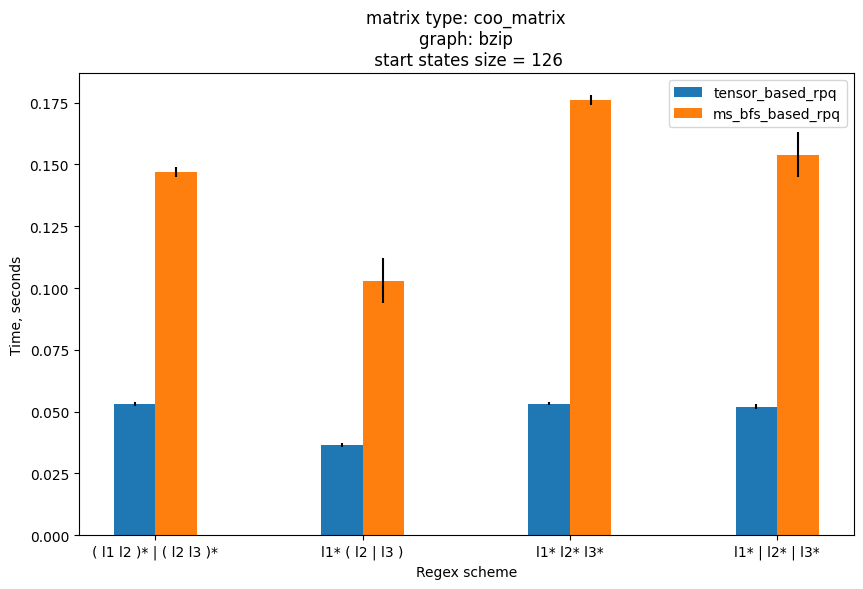

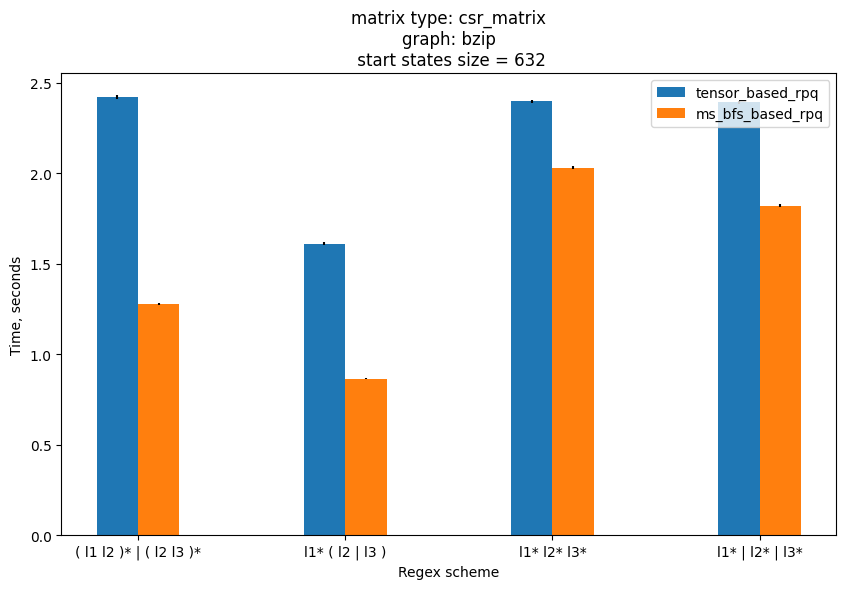

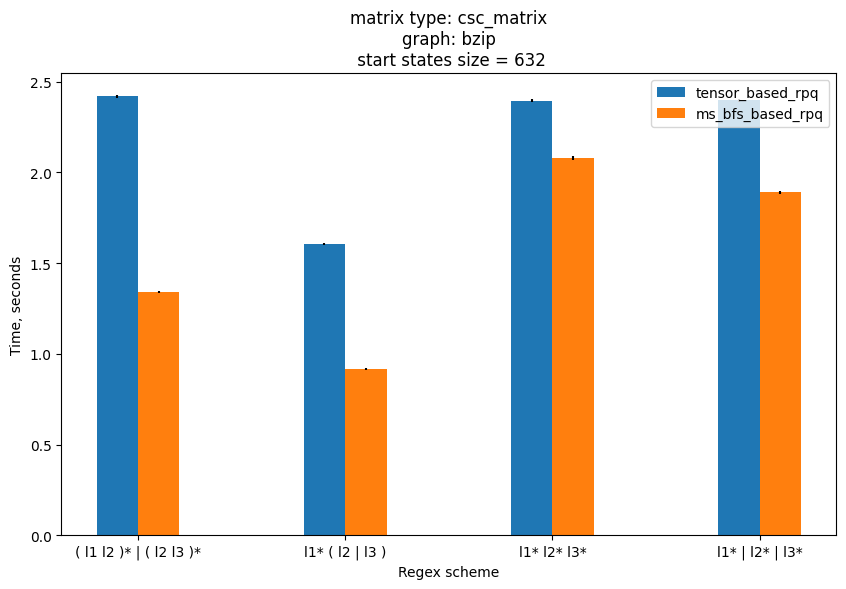

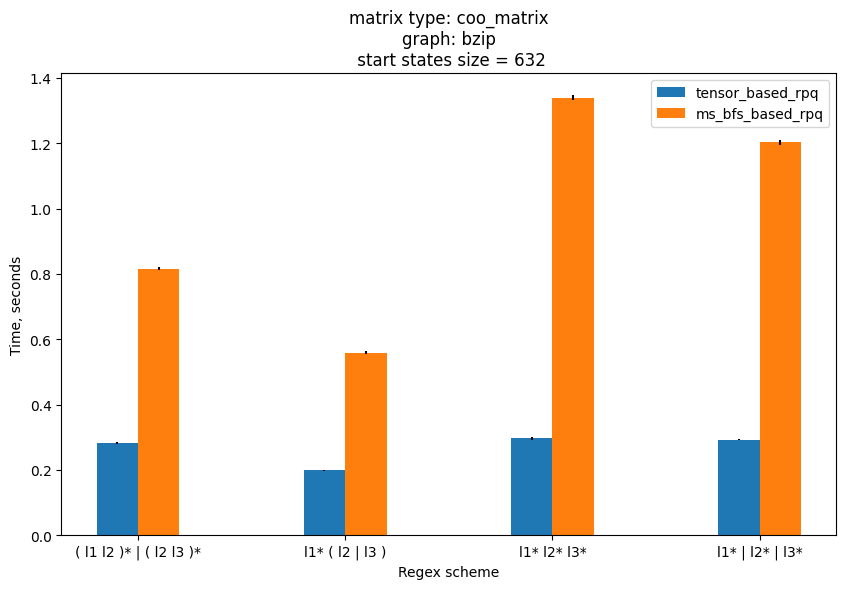

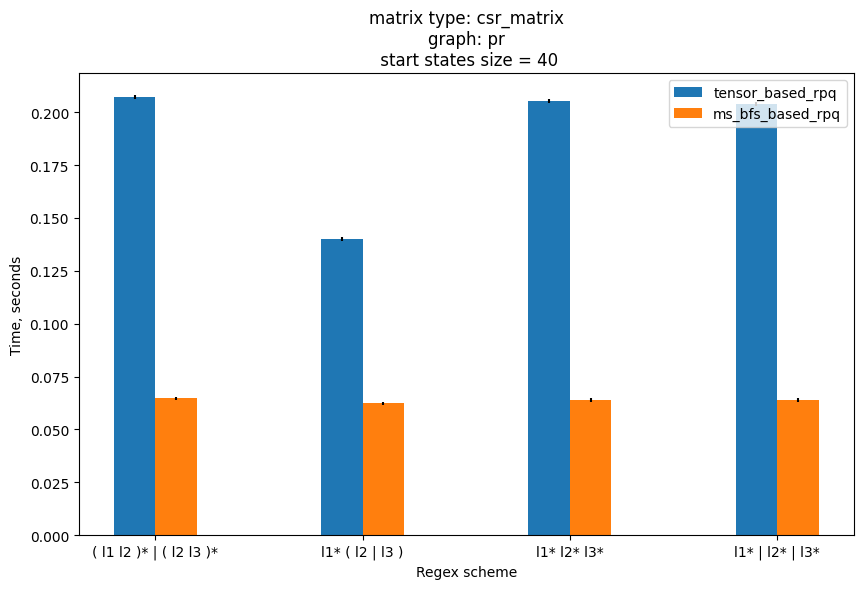

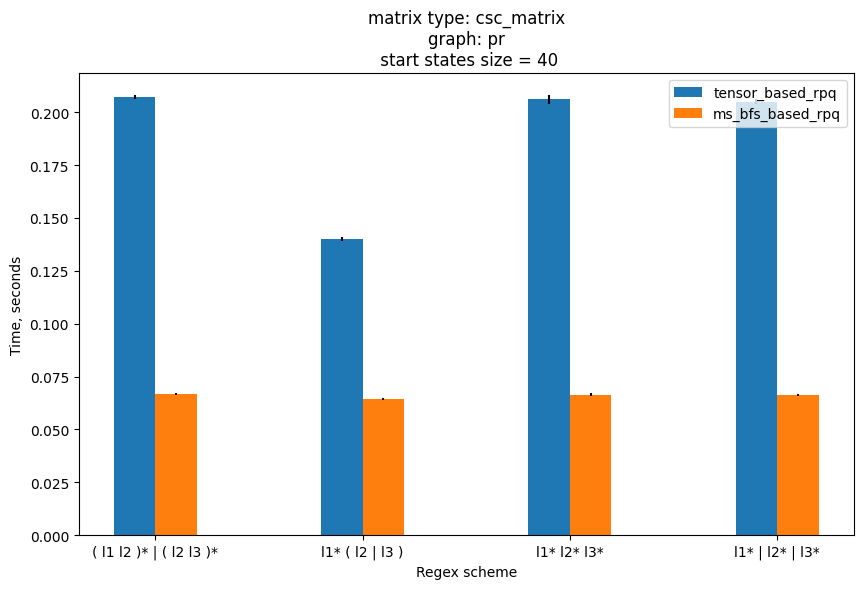

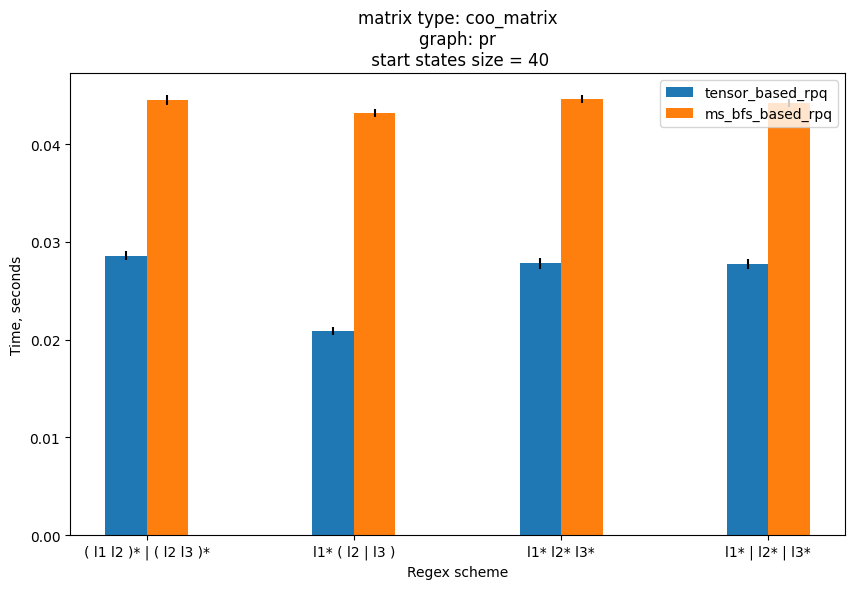

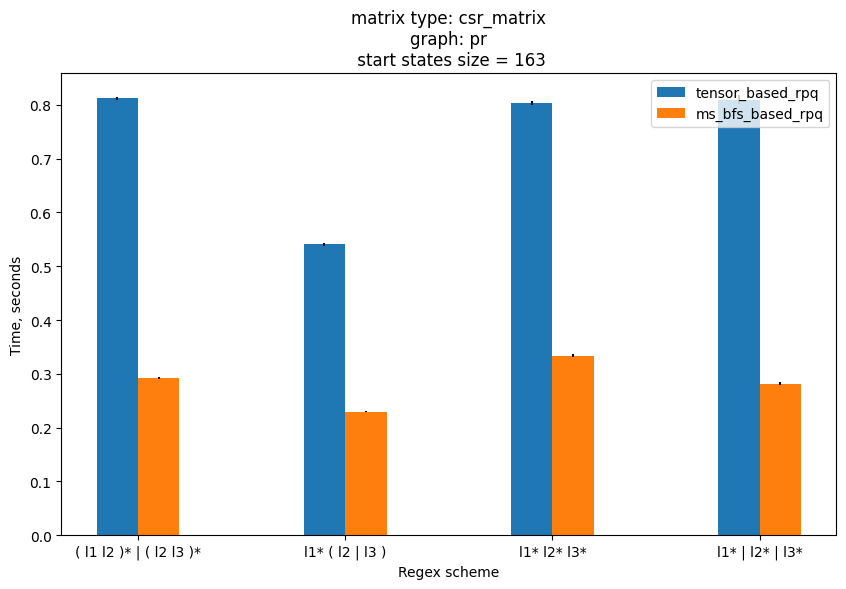

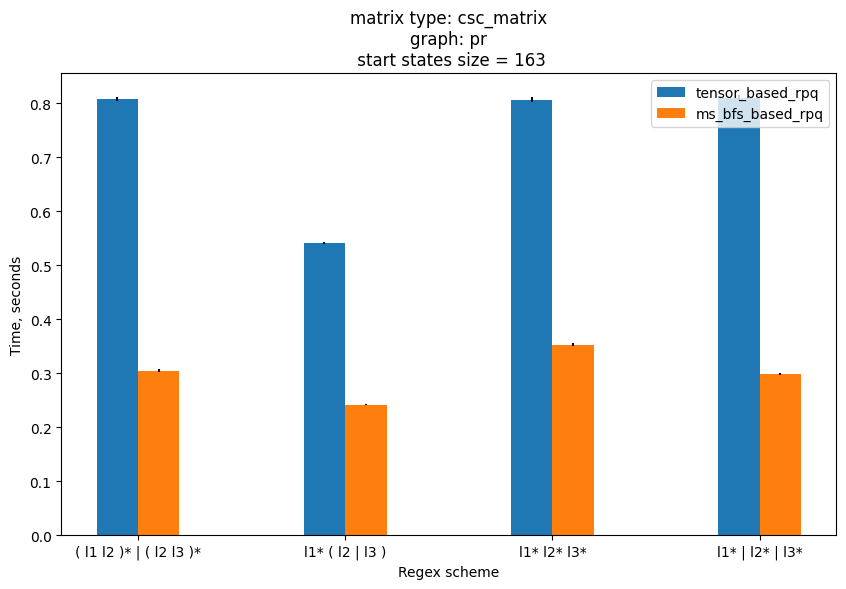

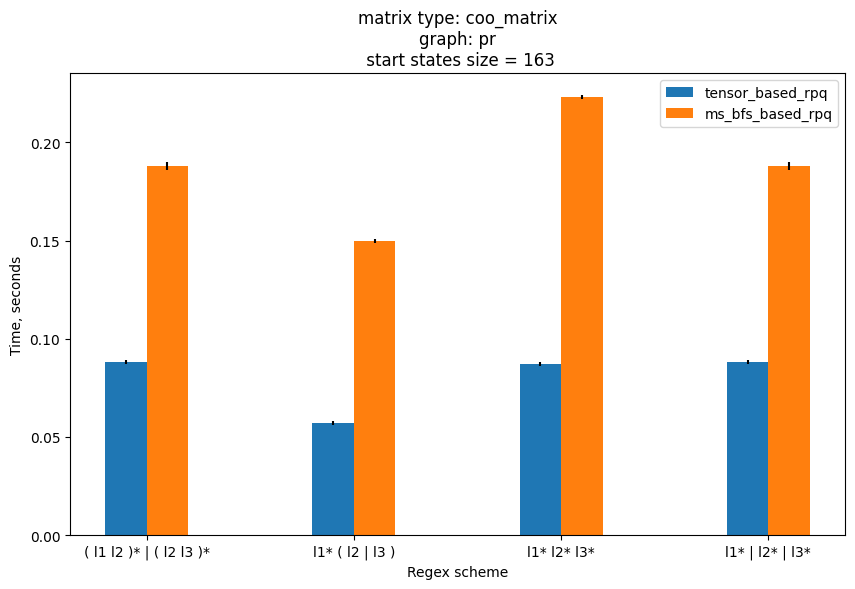

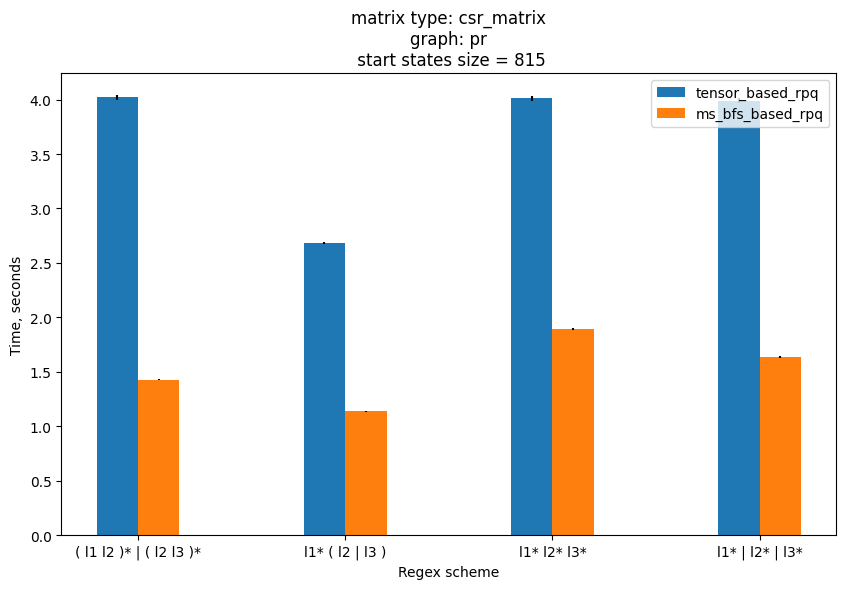

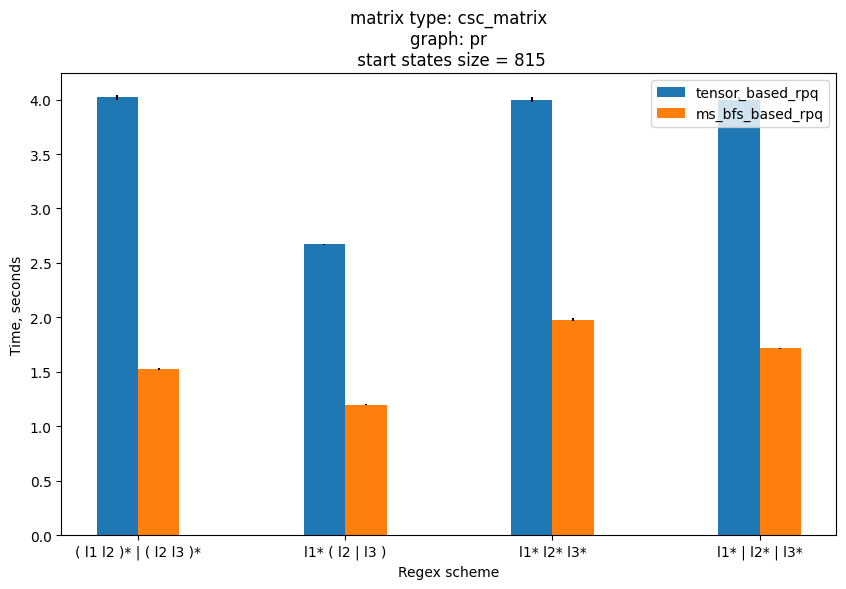

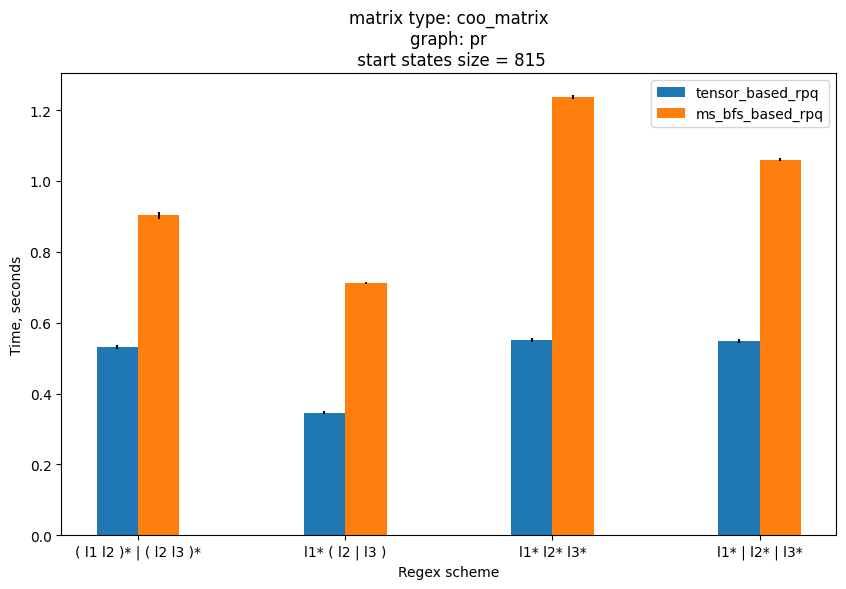

In [12]:
def plot_diff_start_states_results(results):
    grouped_data = defaultdict(lambda: defaultdict(list))

    for result in results:
        key = (result.sparse_matrix_type, result.graph_name, result.start_nodes_number)
        grouped_data[key][result.regex_scheme].append(result)

    for (
        sparse_matrix_type,
        graph_name,
        start_nodes_number,
    ), expr_data in grouped_data.items():
        regex_schemes = sorted(expr_data.keys())

        x = np.arange(len(regex_schemes))
        width = 0.2
        _, ax = plt.subplots(figsize=(10, 6))

        for i, algo_name in enumerate(RPQ_ALGOS):
            times = []
            errors = []
            for regex in regex_schemes:
                found = False
                for res in expr_data[regex]:
                    if res.algorithm_name == algo_name.__name__:
                        times.append(float(res.mean_time))
                        errors.append(float(res.std_time))
                        found = True
                        break
                if not found:
                    times.append(0.0)
                    errors.append(0.0)
            ax.bar(x + i * width, times, width, label=algo_name.__name__, yerr=errors)

        ax.set_xlabel("Regex scheme")
        ax.set_ylabel("Time, seconds")
        ax.set_title(
            f"matrix type: {sparse_matrix_type}\ngraph: {graph_name}\n start states size = {start_nodes_number}"
        )
        ax.set_xticks(x + width * (len(RPQ_ALGOS) - 1) / 2)
        ax.set_xticklabels(regex_schemes)
        ax.legend()
        plt.show()


plot_diff_start_states_results(results)

## Результаты эксперимента

### Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?
 
В ходе эксперимента было выявлено, что при использовании `coo_matrix` среднее время работы алгоритмов решения задач достижимости оказалось меньше (для `tensor_based_rpq` ЗНАЧИТЕЛЬНО меньше). Различие среднего времени выполнения при использовании `csr_matrix` и `csc_matrix` незначительно в обоих алгоритах. 

Значительно меньшее время работы при использовании `coo_matrix`, вероятно, заключается в неэффективном использовании `csr_matrix` и `csc_matrix`, что подтверждается также мини-экспериментом приведенном после основного эксперимента. 

Ответ на поставленный вопрос: для обеих решаемых задач `coo_matrix` представление подходит лучше.

P.S Удалось меньшить время работы `tensor_based_rpq` алгоритма. В приведенных выше результатах времени работы алгоритмов используется уже оптимизированная версия `tensor_based_rpq` для `csr_matrix` и `csc_matrix`.

### Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?

Рассмотрим результаты времени работы алгоритмов для матриц `csr_matrix` и `csc_matrix`. Для графов `gen` и `univ` алгоритм `tensor_based_rpq` оказыается эффективнее почти во всех случаях (`ms_bfs_based_rpq` быстрее только на `univ` при кол-во вершин == `0.05 * общее кол-во вершин`). Для остальных графов алоритм `ms_bfs_based_rpq` работает быстрее.

Однако, при сравнении скорости/использовании алгоритмов важно смотреть на эффективные реализации. Прошлый эксперимент показал, что алгоритмы работают быстрее при использовании `coo_matrix` (`tensor_based_rpq` ЗНАЧИТЕЛЬНО быстрее).  Результаты эксперимента показывают, что `tensor_based_rpq` при использовании `coo_matrix` работает быстрее, чем `ms_bfs_based_rpq` на всех, выбранных для эксперимента данных. 

Ответ на поставленный вопрос: начиная с любого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные.


# Дополнительный мини-эксперимент

При проведении основного эксперимента была замечена неэффективность алгоритма `tensor_based_rpq` при использовании матриц `csr_matrix` и `csc_matrix`.

Была найдена одна из причин этой неэффективности:
```Python
if transitive_closure_matrix[intersect_start_state_ind, intersect_final_state_ind]:
    ...
```

Данная часть кода была заменена:
```Python
start = transitive_closure_matrix.indptr[intersect_start_state_ind]
end = transitive_closure_matrix.indptr[intersect_start_state_ind + 1]
row_indexes = transitive_closure_matrix.indices[start:end]
data = transitive_closure_matrix.data[start:end]

if intersect_final_state_ind in row_indexes:
    idx = row_indexes.tolist().index(intersect_final_state_ind)
    if data[idx]:
        ...
```

Для оценки предположенной оптимизации проведем замеры времени работы алгоритмов на некоторых графах и матрице `csr_matrix` старой реализации алгоритма и предположительно частично оптимизированного алгоритма.

In [13]:
from project.rpq import tensor_based_rpq as old_tensor_based_rpq


@dataclass
class TensorBasedRpqComputingResults:
    algorithm_name: str
    graph_name: str
    regex_scheme: str
    start_nodes_number: int
    mean_time: str
    std_time: str


def compute_tensor_based_rpq_algo(
    graph: nx.MultiDiGraph,
    graph_name: str,
    regex: str,
    regex_scheme: str,
    start_nodes: set[int],
) -> TensorBasedRpqComputingResults:
    times = []
    for _ in range(NUMBER_OF_LAUNCHES):
        time = timeit.timeit(
            lambda: tensor_based_rpq(
                regex, graph, start_nodes, set(), sparse.csr_array
            ),
            number=1,
        )
        times.append(time)

    times = sorted(times)[3:-3]
    mean = np.mean(times)
    std = np.std(times)
    order = max(math.ceil(-math.log10(std)), 0)

    return TensorBasedRpqComputingResults(
        "new_tensor_based_rpq",
        graph_name,
        regex_scheme,
        len(start_nodes),
        f"{mean:.{order}f}",
        f"{std:.{order}f}",
    )


def compute_old_tensor_based_rpq_algo(
    graph: nx.MultiDiGraph,
    graph_name: str,
    regex: str,
    regex_scheme: str,
    start_nodes: set[int],
) -> TensorBasedRpqComputingResults:
    times = []
    for _ in range(NUMBER_OF_LAUNCHES):
        time = timeit.timeit(
            lambda: old_tensor_based_rpq(regex, graph, start_nodes, set()),
            number=1,
        )
        times.append(time)

    times = sorted(times)[3:-3]
    mean = np.mean(times)
    std = np.std(times)
    order = max(math.ceil(-math.log10(std)), 0)

    return TensorBasedRpqComputingResults(
        "old_tensor_based_rpq",
        graph_name,
        regex_scheme,
        len(start_nodes),
        f"{mean:.{order}f}",
        f"{std:.{order}f}",
    )

In [16]:
tensor_results = []

for graph_info in GRAPHS[0:3]:
    graph = graph_info[1]
    graph_name = graph_info[0]
    start_states_list = generate_start_states_list(graph)
    regexes_info = get_regexes_info(graph)
    for start_states in start_states_list:
        for regex_info in regexes_info:
            regex_scheme = regex_info[0]
            regex = regex_info[1]
            tensor_results.append(
                compute_tensor_based_rpq_algo(
                    graph,
                    graph_name,
                    regex,
                    regex_scheme,
                    start_states,
                )
            )
            tensor_results.append(
                compute_old_tensor_based_rpq_algo(
                    graph,
                    graph_name,
                    regex,
                    regex_scheme,
                    start_states,
                )
            )

pd.DataFrame(tensor_results)

[2025-01-28 11:06:40]>INFO>Generate set of source vertices of 6 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000001CFDDDECCB0> for multiple-source evaluation
[2025-01-28 11:06:40]>INFO>Generate set of source vertices of 25 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000001CFDDDECCB0> for multiple-source evaluation
[2025-01-28 11:06:40]>INFO>Generate set of source vertices of 129 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000001CFDDDECCB0> for multiple-source evaluation
[2025-01-28 11:06:40]>INFO>Construct labels_frequency=defaultdict(<class 'int'>, {'rest': 45, 'first': 45, 'onProperty': 27, 'type': 78, 'hasValue': 12, 'someValuesFrom': 15, 'equivalentClass': 17, 'intersectionOf': 18, 'inverseOf': 2, 'range': 1, 'hasSibling': 1, 'sameAs': 2, 'hasParent': 2, 'hasSex': 4, 'hasChild': 2, 'versionInfo': 1, 'oneOf': 1}) for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x000001CFDDDECCB0>
[2025

,algorithm_name,graph_name,regex_scheme,start_nodes_number,mean_time,std_time
0,new_tensor_based_rpq,generations,l1* ( l2 | l3 ),6,0.0063,0.0004
1,old_tensor_based_rpq,generations,l1* ( l2 | l3 ),6,0.0102,0.0005
2,new_tensor_based_rpq,generations,l1* | l2* | l3*,6,0.0107,0.0005
3,old_tensor_based_rpq,generations,l1* | l2* | l3*,6,0.025,0.001
4,new_tensor_based_rpq,generations,l1* l2* l3*,6,0.0089,0.0002
...,...,...,...,...,...,...
67,old_tensor_based_rpq,foaf,l1* | l2* | l3*,256,1.658,0.008
68,new_tensor_based_rpq,foaf,l1* l2* l3*,256,0.398,0.003
69,old_tensor_based_rpq,foaf,l1* l2* l3*,256,1.259,0.007
70,new_tensor_based_rpq,foaf,( l1 l2 )* | ( l2 l3 )*,256,0.400,0.001


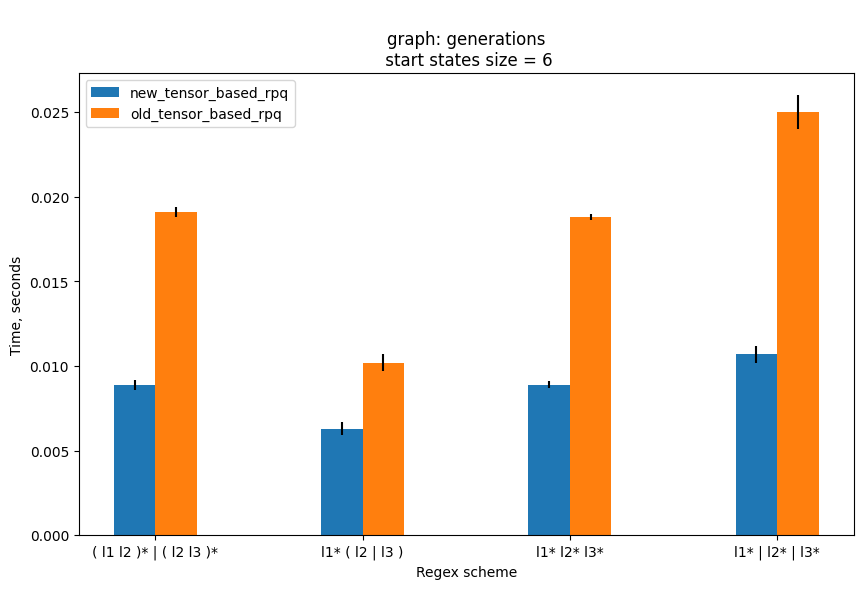

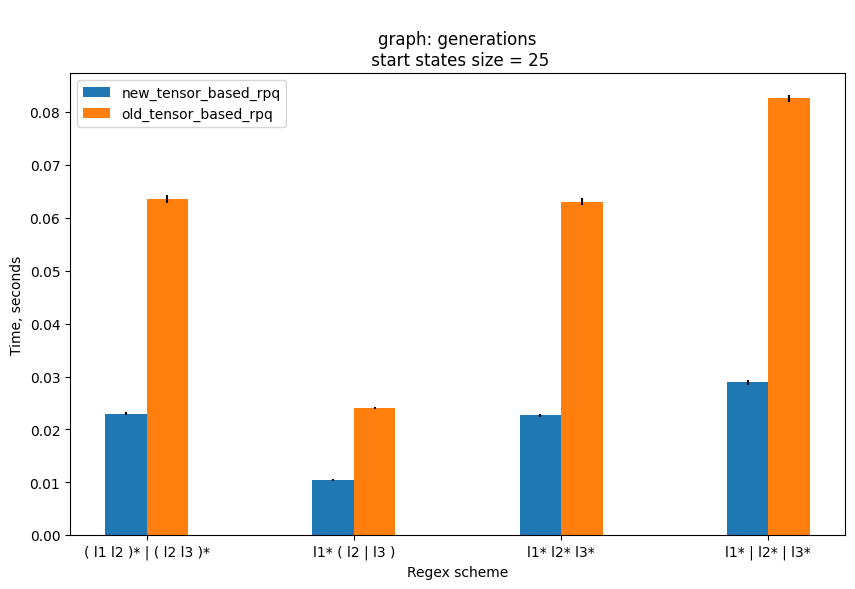

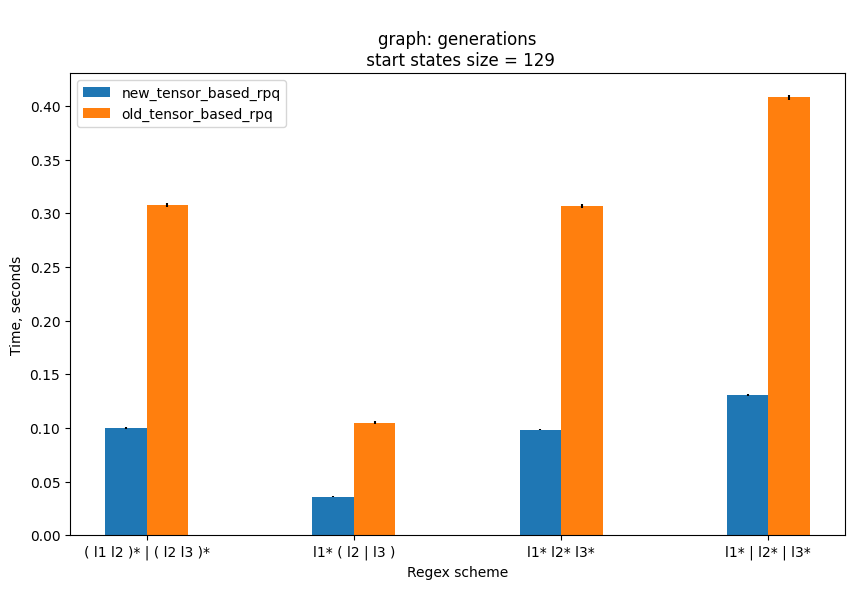

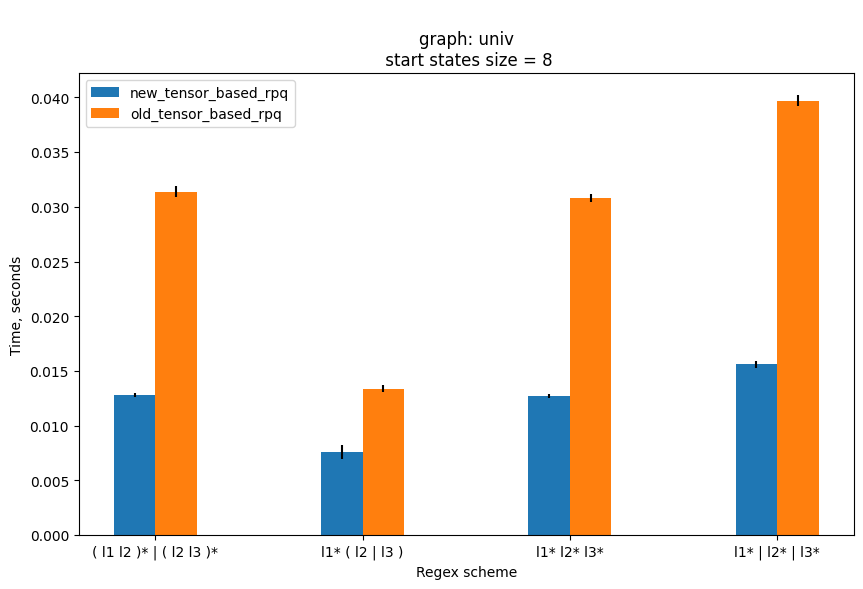

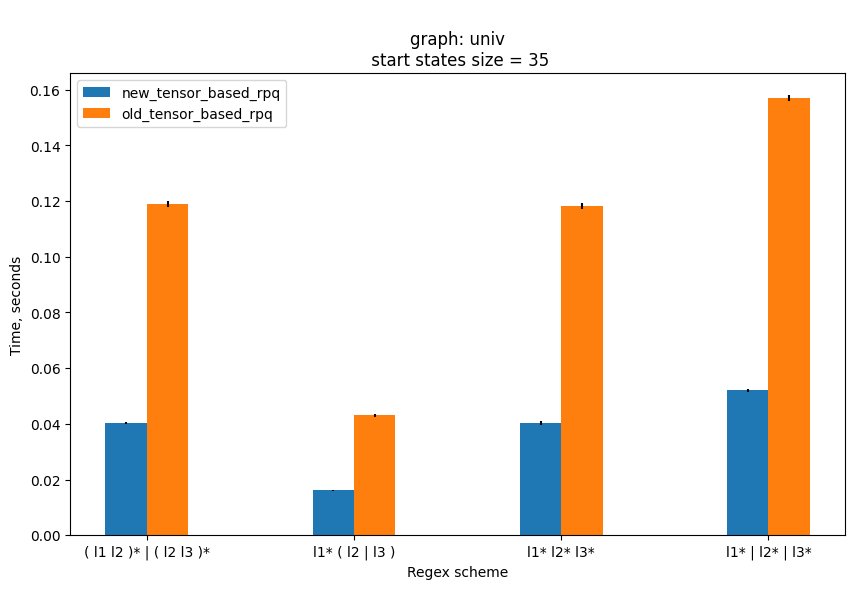

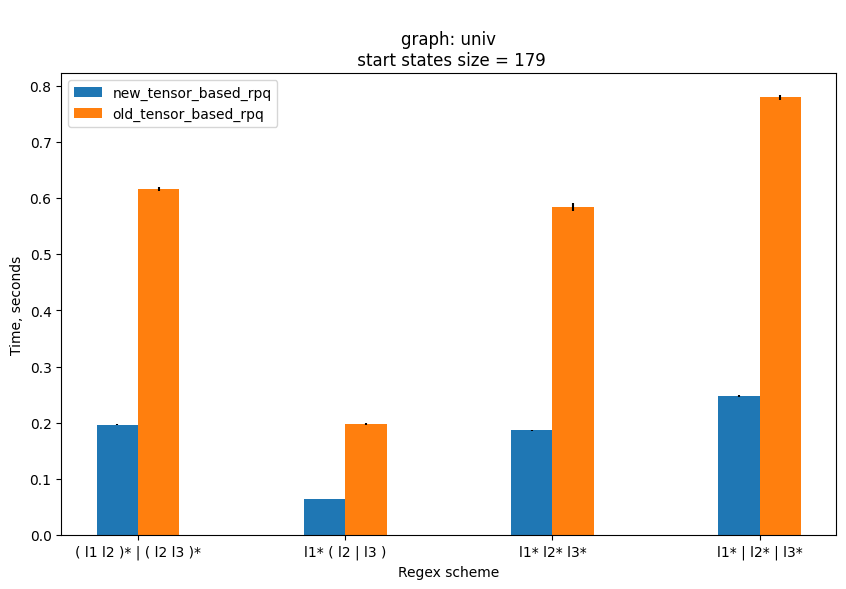

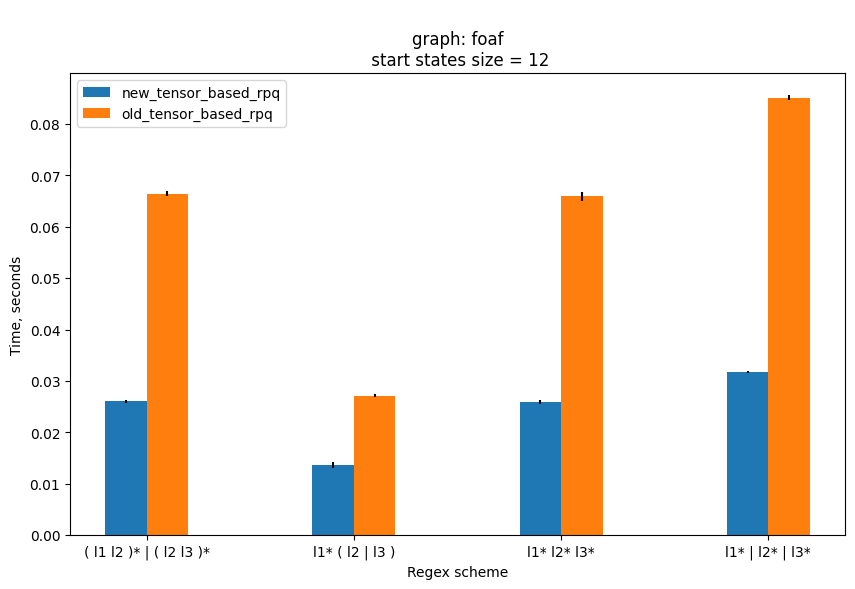

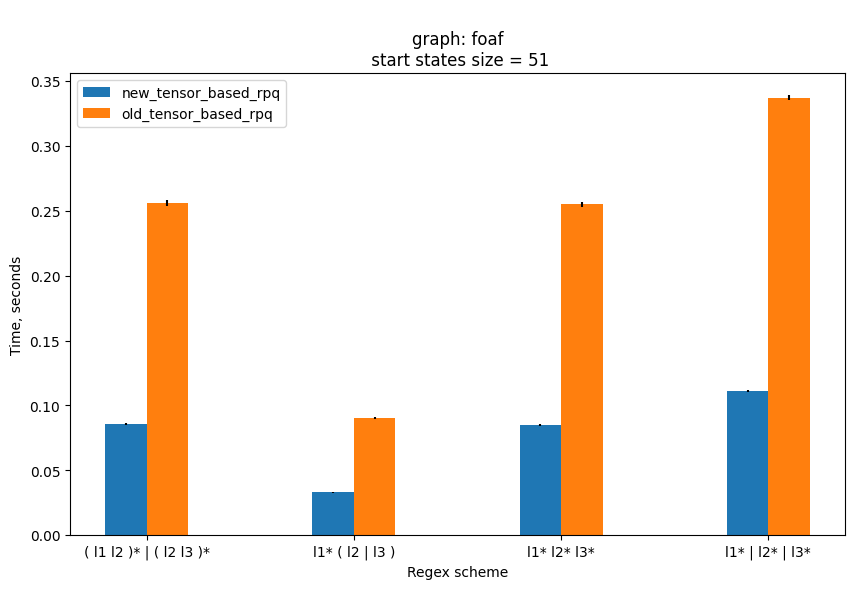

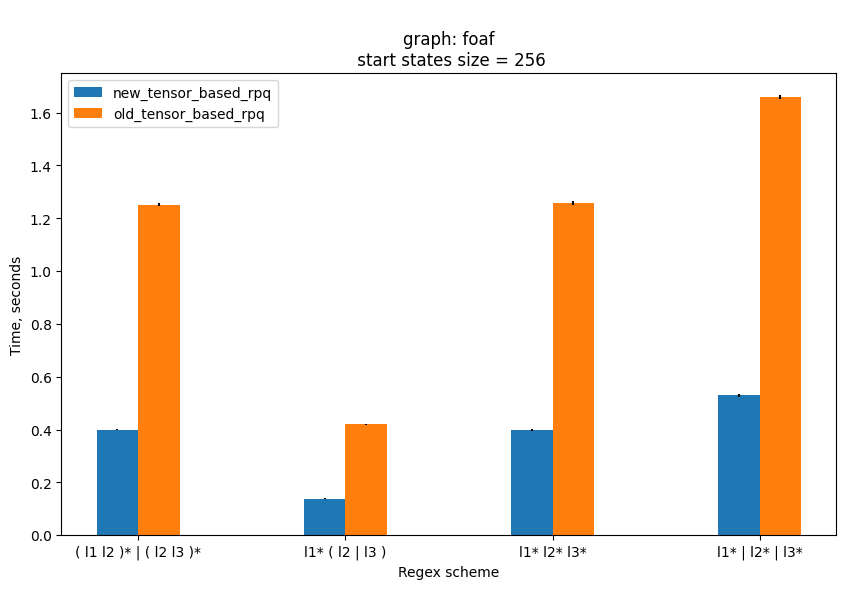

In [17]:
def plot_diff_tensor_based_rpq_results(tensor_results):
    grouped_data = defaultdict(lambda: defaultdict(list))

    for result in tensor_results:
        key = (result.graph_name, result.start_nodes_number)
        grouped_data[key][result.regex_scheme].append(result)

    for (
        graph_name,
        start_nodes_number,
    ), expr_data in grouped_data.items():
        regex_schemes = sorted(expr_data.keys())

        x = np.arange(len(regex_schemes))
        width = 0.2
        _, ax = plt.subplots(figsize=(10, 6))

        for i, algo_name in enumerate(["new_tensor_based_rpq", "old_tensor_based_rpq"]):
            times = []
            errors = []
            for regex in regex_schemes:
                found = False
                for res in expr_data[regex]:
                    if res.algorithm_name == algo_name:
                        times.append(float(res.mean_time))
                        errors.append(float(res.std_time))
                        found = True
                        break
                if not found:
                    times.append(0.0)
            ax.bar(x + i * width, times, width, label=algo_name, yerr=errors)

        ax.set_xlabel("Regex scheme")
        ax.set_ylabel("Time, seconds")
        ax.set_title(
            f"\ngraph: {graph_name}\n start states size = {start_nodes_number}"
        )
        ax.set_xticks(x + width * (len(RPQ_ALGOS) - 1) / 2)
        ax.set_xticklabels(regex_schemes)
        ax.legend()
        plt.show()


plot_diff_tensor_based_rpq_results(tensor_results)

## Результаты мини-эксперимента

Результаты показали, что после замены неэффективной части кода (работа с матрицей), алгоритм стал работать значительно быстрее.
Время выполнения алгоритма уменьшилось в 2-3 раза!